In [1]:
import os
import json
import torch
import random
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from transformer_lens import HookedTransformer
from utils import *
from sentences import location_sentences, name_sentences, love_hate_sentences
from statsmodels.stats.proportion import proportions_ztest
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
pythia = HookedTransformer.from_pretrained(
    'EleutherAI/pythia-70m-deduped',
    device=device,
    local_files_only=True,
)
pythia.eval()

gpt2 = HookedTransformer.from_pretrained(
    'gpt2-small',
    device=device,
    local_files_only=True,
)
gpt2.eval()
pythia_embedding = pythia.embed.W_E.detach()
gpt2_embedding = gpt2.embed.W_E.detach()

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer
Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
with open('./pythia_token_str_type.json', 'r') as f:
    pythia_token_str_type = json.load(f)
with open('./gpt2_token_str_type.json', 'r') as f:
    gpt2_token_str_type = json.load(f)

def inject_tokens(sentence, tokens):
    return f"({''.join(tokens)}){sentence}"

def get_next_token_probs(model, text, top_k=10):
    tokens = model.to_tokens(text).to(device)
    with torch.no_grad():
        top_logits = model(tokens)[0, -1, :]
    probs = torch.softmax(top_logits, dim=-1)
    top_k_probs, top_k_indices = torch.topk(probs, top_k)
    return [(idx.item(),
            model.to_string(idx.item()),
            prob.item())
           for idx, prob in zip(top_k_indices, top_k_probs)]

def get_weighted_cosine_similarity(embeddings, token_ids, token_probs, target_ids):
    """
    Calculate weighted cosine similarity using matrix operations
    Args:
        embeddings: embedding matrix
        token_ids: output token ids
        token_probs: probability weights for output tokens
        target_ids: target token ids to compare against
    """
    # Get embeddings for both sets of tokens
    output_token_embeddings = embeddings[token_ids]  # shape: [n_tokens, embed_dim]
    target_token_embeddings = embeddings[target_ids]  # shape: [n_targets, embed_dim]
    
    # Normalize embeddings
    output_token_embeddings = F.normalize(output_token_embeddings, p=2, dim=1)
    target_token_embeddings = F.normalize(target_token_embeddings, p=2, dim=1)
    
    # Calculate cosine similarity matrix using matmul
    similarity_matrix = torch.matmul(output_token_embeddings, target_token_embeddings.T)
    
    # Get max similarity for each output token
    max_similarities = torch.max(similarity_matrix, dim=1)[0]  # shape: [n_tokens]
    
    if not isinstance(token_probs, torch.Tensor):
        token_probs_tensor = torch.tensor(token_probs, device=max_similarities.device)
    else:
        token_probs_tensor = token_probs.clone().detach().to(max_similarities.device)
    
    # Apply token probabilities as weights
    weighted_similarities = max_similarities * token_probs_tensor
    
    # Sum up all weighted similarities
    total_similarity = torch.sum(weighted_similarities).item()
    
    return total_similarity

def get_weighted_overlap(token_ids, target_ids, token_probs):
    # calculate the overlap between token_ids and target_ids
    overlap = 0
    for i, token_id in enumerate(token_ids):
        if token_id in target_ids:
            overlap += token_probs[i]
    return overlap

def get_best_rank(token_ids, target_ids):
    # calculate the rank of the best token in token_ids
    # that is also in target_ids
    best_rank = None
    for i, token_id in enumerate(token_ids):
        if token_id in target_ids:
            if best_rank is None or i < best_rank:
                best_rank = i

    return best_rank

def compare_binary_sequences(seq1, seq2, alpha=0.05, method='proportion'):
    """Compare two binary sequences using statistical tests"""
    seq1 = np.array(seq1)
    seq2 = np.array(seq2)
    
    if not np.all(np.isin(seq1, [0, 1])) or not np.all(np.isin(seq2, [0, 1])):
        raise ValueError("sequences must only contain 0s and 1s")
    
    mean1 = np.mean(seq1)
    mean2 = np.mean(seq2)
    
    count1 = np.sum(seq1)
    count2 = np.sum(seq2)
    nobs1 = len(seq1)
    nobs2 = len(seq2)
    
    if method == 'proportion':
        count = np.array([count1, count2])
        nobs = np.array([nobs1, nobs2])
        stat, pvalue = proportions_ztest(count, nobs)
        
    return {
        'mean1': mean1,
        'mean2': mean2,
        'difference': mean1 - mean2,
        'p_value': pvalue,
        'significant': pvalue < alpha,
        'conclusion': f"difference is {'significant' if pvalue < alpha else 'not significant'} (p = {pvalue:.4f})"
    }

def run_injection_experiment(model, sentence, injection_tokens, n_trials, target_ids):
    """
    Run injection experiments with multiple metrics
    Args:
        model: HookedTransformer model
        sentence: input sentence
        injection_tokens: tokens to inject 
        n_trials: number of trials
        target_ids: target token ids to measure against
    Returns:
        dict with success rates and detailed metrics
    """
    results = {
        'count_increases': 0,
        'prob_increases': 0,
        'total_trials': n_trials,
        'detailed_metrics': []
    }

    original_top_k = get_next_token_probs(model, sentence)
    original_ids = [t[0] for t in original_top_k] 
    original_probs = [t[2] for t in original_top_k]
    
    original_count = sum(1 for tid in original_ids if tid in target_ids)
    original_prob = sum(p for tid, p in zip(original_ids, original_probs) if tid in target_ids)
    
    original_sim = get_weighted_cosine_similarity(
        model.embed.W_E.detach(),
        torch.tensor(original_ids),
        torch.tensor(original_probs),
        torch.tensor(target_ids)
    )
    original_overlap = get_weighted_overlap(
        original_ids,
        target_ids,
        original_probs
    )
    original_best_rank = get_best_rank(original_ids, target_ids)
    
    for _ in range(n_trials):
        selected_tokens = random.sample(injection_tokens, 10)
        injected_sentence = inject_tokens(sentence, selected_tokens)
        
        injected_top_k = get_next_token_probs(model, injected_sentence)
        injected_ids = [t[0] for t in injected_top_k]
        injected_probs = [t[2] for t in injected_top_k]
        
        # get two success counts
        injected_count = sum(1 for tid in injected_ids if tid in target_ids)
        injected_prob = sum(p for tid, p in zip(injected_ids, injected_probs) if tid in target_ids)
        
        # get similarity after injection
        injected_sim = get_weighted_cosine_similarity(
            model.embed.W_E.detach(),
            torch.tensor(injected_ids),
            torch.tensor(injected_probs),
            torch.tensor(target_ids)
        )
        
        # get overlap after injection
        injected_overlap = get_weighted_overlap(
            injected_ids,
            target_ids,
            injected_probs
        )
        
        # get best rank after injection
        injected_best_rank = get_best_rank(injected_ids, target_ids)
        
        # record trial metrics
        trial_metrics = {
            'injected_tokens': selected_tokens,
            'injected_top_k': injected_top_k,
            'original_count': original_count,
            'injected_count': injected_count,
            'original_prob': original_prob,
            'injected_prob': injected_prob,
            'similarity_change': float(injected_sim - original_sim),
            'overlap_change': float(injected_overlap - original_overlap),
            'rank_change': None if original_best_rank is None or injected_best_rank is None 
                          else float(original_best_rank - injected_best_rank)
        }
        results['detailed_metrics'].append(trial_metrics)
        
        # get success counts
        if injected_count > original_count:
            results['count_increases'] += 1
        if injected_prob > original_prob:
            results['prob_increases'] += 1

    return results

def compare_all_groups(results, exp_type, model_name):
    """
    Compare metrics between different token groups and random baseline
    Args:
        results: experiment results dictionary
        exp_type: experiment type (location/name/love_hate)
        model_name: model name (Pythia/GPT-2)
    """
    # Initialize binary sequences preserving temporal order
    group_sequences = {
        'target': [],
        'high_interference': [],
        'medium_interference': [],
        'random': []
    }
    
    # Collect metric changes
    metrics = {
        'target': {'sim': [], 'overlap': [], 'rank': []},
        'high_interference': {'sim': [], 'overlap': [], 'rank': []},
        'medium_interference': {'sim': [], 'overlap': [], 'rank': []}, 
        'random': {'sim': [], 'overlap': [], 'rank': []}
    }
    
    # Convert results to binary sequences maintaining order
    for group in group_sequences:
        for result in results[group]:
            # Get original and injected counts for each trial
            for record in result['results']['detailed_metrics']:
                # Add 1 if count increased, 0 if not
                count_increased = 1 if record['injected_count'] > record['original_count'] else 0
                group_sequences[group].append(count_increased)
                
                # Collect all metric changes
                metrics[group]['sim'].append(record['similarity_change'])
                metrics[group]['overlap'].append(record['overlap_change'])
                if record['rank_change'] is not None:
                    metrics[group]['rank'].append(record['rank_change'])
    
    # Run statistical tests comparing with random baseline
    target_vs_random = compare_binary_sequences(
        group_sequences['target'], 
        group_sequences['random']
    )
    high_vs_random = compare_binary_sequences(
        group_sequences['high_interference'],
        group_sequences['random']
    )
    medium_vs_random = compare_binary_sequences(
        group_sequences['medium_interference'],
        group_sequences['random']
    )
    
    print(f"\n=== {model_name} {exp_type} Statistical Analysis ===")
    
    # Print statistical test results vs random baseline
    print("\nTarget vs Random:")
    print(f"Difference: {target_vs_random['difference']:.4f}")
    print(f"p-value: {target_vs_random['p_value']:.4f}")
    print(f"Statistical significance: {target_vs_random['conclusion']}")
    
    print("\nHigh Interference vs Random:")
    print(f"Difference: {high_vs_random['difference']:.4f}")
    print(f"p-value: {high_vs_random['p_value']:.4f}")
    print(f"Statistical significance: {high_vs_random['conclusion']}")
    
    print("\nMedium Interference vs Random:")
    print(f"Difference: {medium_vs_random['difference']:.4f}")
    print(f"p-value: {medium_vs_random['p_value']:.4f}")
    print(f"Statistical significance: {medium_vs_random['conclusion']}")

def print_experiment_results(results_dict, model_name, exp_type):
    """
    Print success rates for all interference levels
    """
    print(f"\n=== {model_name} {exp_type} Experiment Results ===")
    token_types = ['target', 'high_interference', 'medium_interference', 'random']
    
    # compute total trials
    total_trials = results_dict['target'][0]['results']['total_trials'] * len(results_dict['target'])
    
    for token_type in token_types:
        count_increases = sum(result['results']['count_increases'] 
                            for result in results_dict[token_type])
        prob_increases = sum(result['results']['prob_increases'] 
                           for result in results_dict[token_type])
        
        count_success_rate = (count_increases / total_trials) * 100
        prob_success_rate = (prob_increases / total_trials) * 100
        
        print(f"\n{token_type}:")
        print(f"Top-10 token count increase rate: {count_success_rate:.2f}% ({count_increases}/{total_trials})")
        print(f"Top-10 token probability sum increase rate: {prob_success_rate:.2f}% ({prob_increases}/{total_trials})")

def plot_injection_metrics(results, model_name, exp_type):
    """
    Plot injection metrics comparison for different token sets
    Only consider positive changes (improvements)
    """
    # Prepare data
    token_sets = ['target', 'high_interference', 'medium_interference', 'random']
    display_labels = ['Original', 'High', 'Low', 'Random']
    metrics = {
        'similarity': {'name': 'Semantic Similarity', 'ylabel': 'Mean Similarity Improvement', 'data': defaultdict(list)},
        'overlap': {'name': 'Token Overlap', 'ylabel': 'Mean Overlap Improvement', 'data': defaultdict(list)},
        'rank': {'name': 'Best Rank Change', 'ylabel': 'Mean Rank Improvement', 'data': defaultdict(list)}
    }
    
    # choose different colors for each model
    if model_name == "Pythia":
        # blue style
        colors = ['#0D47A1', '#1565C0', '#1976D2', '#1E88E5']
    else:  # GPT-2
        # green style
        colors = ['#004D40', '#00695C', '#00796B', '#00897B']
    
    # get improvement records
    for token_type in token_sets:
        for result in results[token_type]:
            for record in result['results']['detailed_metrics']:
                #if record['similarity_change'] > 0:
                metrics['similarity']['data'][token_type].append(record['similarity_change'])
                #if record['overlap_change'] > 0:
                metrics['overlap']['data'][token_type].append(record['overlap_change'])
                if record['rank_change'] is not None: # and record['rank_change'] > 0
                    metrics['rank']['data'][token_type].append(record['rank_change'])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
    for idx, (metric_key, metric_info) in enumerate(metrics.items()):
        ax = axes[idx]
        
        means = []
        sems = []
        success_rates = []
        
        for token_type in token_sets:
            data = metric_info['data'][token_type]
            if len(data) > 0:
                means.append(np.mean(data))
                sems.append(np.std(data) / np.sqrt(len(data)))
                total_trials = sum(len(r['results']['detailed_metrics']) 
                                 for r in results[token_type])
                success_rate = len(data) / total_trials * 100
                success_rates.append(success_rate)
            else:
                means.append(0)
                sems.append(0)
                success_rates.append(0)
        
        x_pos = np.arange(len(token_sets))
        bars = ax.bar(x_pos, means, color=colors,
                     yerr=sems, capsize=5,
                     error_kw={'ecolor': 'black', 'linewidth': 1, 'capthick': 1})
        
        for idx, (bar, rate) in enumerate(zip(bars, success_rates)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + sems[idx],
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=8)
        
        ax.set_xlabel('Token Interference Level', fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels)
        ax.grid(axis='y', linestyle='-', alpha=0.2)
        ax.set_ylabel(metric_info['ylabel'], fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_best_improvements(results, model_name, exp_type):
    """
    Plot best improvement distributions for each metric across sentences
    Args:
        results: experiment results dictionary
        model_name: model name (Pythia/GPT-2)
        exp_type: experiment type (location/name/love_hate)
    """
    token_sets = ['target', 'high_interference', 'medium_interference', 'random']
    display_labels = ['Original', 'High', 'Low', 'Random']
    metrics = {
        'similarity': {'name': 'Semantic Similarity', 'ylabel': 'Best Similarity Improvement', 'data': defaultdict(list)},
        'overlap': {'name': 'Token Overlap', 'ylabel': 'Best Overlap Improvement', 'data': defaultdict(list)},
        'rank': {'name': 'Best Rank', 'ylabel': 'Best Rank Improvement', 'data': defaultdict(list)}
    }
    
    if model_name == "Pythia":
        colors = ['#0D47A1', '#1565C0', '#1976D2', '#1E88E5']
    else:
        colors = ['#004D40', '#00695C', '#00796B', '#00897B']
    
    # Get best improvements for each sentence
    for token_type in token_sets:
        for sentence_result in results[token_type]:
            best_sim_change = float('-inf')
            best_overlap_change = float('-inf')
            best_rank_change = float('-inf')
            
            for record in sentence_result['results']['detailed_metrics']:
                sim_change = record['similarity_change']
                if sim_change > best_sim_change:
                    best_sim_change = sim_change
                    
                overlap_change = record['overlap_change']
                if overlap_change > best_overlap_change:
                    best_overlap_change = overlap_change
                    
                if record['rank_change'] is not None:
                    rank_change = record['rank_change']
                    if rank_change > best_rank_change:
                        best_rank_change = rank_change
            
            if best_sim_change > float('-inf'):
                metrics['similarity']['data'][token_type].append(best_sim_change)
            if best_overlap_change > float('-inf'):
                metrics['overlap']['data'][token_type].append(best_overlap_change)
            if best_rank_change > float('-inf'):
                metrics['rank']['data'][token_type].append(best_rank_change)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
    
    for idx, (metric_key, metric_info) in enumerate(metrics.items()):
        ax = axes[idx]
        means = []
        sems = []
        
        for token_type in token_sets:
            data = metric_info['data'][token_type]
            if len(data) > 0:
                means.append(np.mean(data))
                sems.append(np.std(data) / np.sqrt(len(data)))
            else:
                means.append(0)
                sems.append(0)
        
        x_pos = np.arange(len(token_sets))
        bars = ax.bar(x_pos, means, color=colors,
                     yerr=sems, capsize=5,
                     error_kw={'ecolor': 'black', 'linewidth': 1, 'capthick': 1})
        
        # Add value labels
        for idx, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + sems[idx],
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=8)
        
        ax.set_xlabel('Token Interference Level', fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels)
        ax.grid(axis='y', linestyle='-', alpha=0.2)
        ax.set_ylabel(metric_info['ylabel'], fontsize=10)
    
    plt.tight_layout()
    plt.show()

### Location Tokens

In [16]:
# Load interference data
with open('./corpus/pythia_non_location_interference.json', 'r') as f:
    pythia_non_location_interference = json.load(f)
with open('./corpus/gpt2_non_location_interference.json', 'r') as f:
    gpt2_non_location_interference = json.load(f)

# Get location token strings and ids
pythia_location_strs = []
pythia_location_ids = []
for token_str, token_type in tqdm(pythia_token_str_type.items()):
    if token_type == 'location':
        pythia_location_strs.append(token_str)
        # Convert to token id without BOS token
        token_id = pythia.to_tokens(token_str, prepend_bos=False)[0]
        if len(token_id) == 1:
            pythia_location_ids.append(token_id.item())
        else:
            pythia_location_ids.append(token_id[0].item())

gpt2_location_strs = []
gpt2_location_ids = []
for token_str, token_type in tqdm(gpt2_token_str_type.items()):
    if token_type == 'location':
        gpt2_location_strs.append(token_str)
        # Convert to token id without BOS token
        token_id = gpt2.to_tokens(token_str, prepend_bos=False)[0]
        if len(token_id) == 1:
            gpt2_location_ids.append(token_id.item())
        else:
            gpt2_location_ids.append(token_id[0].item())

# Get high/medium interference tokens for location
pythia_loc_high_interference_tokens = set()
pythia_loc_low_interference_tokens = set()
for layer_type, layer_type_data in tqdm(pythia_non_location_interference.items()):
    for layer_id, interference_pairs in layer_type_data.items():
        for interference_pair in interference_pairs:
            if interference_pair['interference_value'] > 0.5:
                pythia_loc_high_interference_tokens.add(interference_pair['interfering_token'])
            elif interference_pair['interference_value'] > 0.2:
                pythia_loc_low_interference_tokens.add(interference_pair['interfering_token'])

gpt2_loc_high_interference_tokens = set()
gpt2_loc_low_interference_tokens = set()
for layer_type, layer_type_data in tqdm(gpt2_non_location_interference.items()):
    for layer_id, interference_pairs in layer_type_data.items():
        for interference_pair in interference_pairs:
            if interference_pair['interference_value'] > 0.5:
                gpt2_loc_high_interference_tokens.add(interference_pair['interfering_token'])
            elif interference_pair['interference_value'] > 0.2:
                gpt2_loc_low_interference_tokens.add(interference_pair['interfering_token'])

pythia_loc_high_interference_tokens = list(pythia_loc_high_interference_tokens)
pythia_loc_low_interference_tokens = list(pythia_loc_low_interference_tokens)
gpt2_loc_high_interference_tokens = list(gpt2_loc_high_interference_tokens)
gpt2_loc_low_interference_tokens = list(gpt2_loc_low_interference_tokens)

# Get random tokens (excluding location tokens and interference tokens)
pythia_loc_random_tokens = []
gpt2_loc_random_tokens = []
for token_str, token_type in tqdm(pythia_token_str_type.items()):
    if (token_str not in pythia_location_strs and 
        token_str not in pythia_loc_high_interference_tokens and 
        token_str not in pythia_loc_low_interference_tokens):
        pythia_loc_random_tokens.append(token_str)
for token_str, token_type in tqdm(gpt2_token_str_type.items()):
    if (token_str not in gpt2_location_strs and 
        token_str not in gpt2_loc_high_interference_tokens and 
        token_str not in gpt2_loc_low_interference_tokens):
        gpt2_loc_random_tokens.append(token_str)

# Print statistics
print("=== Experiment Configuration ===")
print("Pythia Model:")
print(f"Location tokens: {len(pythia_location_strs)}")
print(f"High Interference Tokens (>0.5): {len(pythia_loc_high_interference_tokens)}")
print(f"Mid Interference Tokens (0.2-0.5): {len(pythia_loc_low_interference_tokens)}")
print(f"Random Tokens: {len(pythia_loc_random_tokens)}")

print("\nGPT-2 Model:")
print(f"Location tokens: {len(gpt2_location_strs)}")
print(f"High Interference Tokens (>0.5): {len(gpt2_loc_high_interference_tokens)}")
print(f"Mid Interference Tokens (0.2-0.5): {len(gpt2_loc_low_interference_tokens)}")
print(f"Random Tokens: {len(gpt2_loc_random_tokens)}")

  0%|          | 0/49069 [00:00<?, ?it/s]

  0%|          | 0/49727 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/49069 [00:00<?, ?it/s]

  0%|          | 0/49727 [00:00<?, ?it/s]

=== Experiment Configuration ===
Pythia Model:
Location tokens: 752
High Interference Tokens (>0.5): 1309
Mid Interference Tokens (0.2-0.5): 21310
Random Tokens: 27721

GPT-2 Model:
Location tokens: 1100
High Interference Tokens (>0.5): 932
Mid Interference Tokens (0.2-0.5): 34958
Random Tokens: 14203


In [17]:
# Set random seed
random.seed(42)
n_trials = 100
token_types = ['target', 'high_interference', 'medium_interference', 'random']

# Pythia experiments
print("\n=== Running Pythia Location Experiments ===")
pythia_results = {token_type: [] for token_type in token_types}

for sentence in tqdm(location_sentences[:100]):
    torch.cuda.empty_cache()
    
    # 1. Target (location) tokens test
    target_results = run_injection_experiment(
        pythia, sentence, pythia_location_strs, 
        n_trials, pythia_location_ids
    )
    pythia_results['target'].append({
        'sentence': sentence,
        'results': target_results
    })
    
    # 2. High interference tokens test
    high_results = run_injection_experiment(
        pythia, sentence, pythia_loc_high_interference_tokens,
        n_trials, pythia_location_ids
    )
    pythia_results['high_interference'].append({
        'sentence': sentence,
        'results': high_results
    })
    
    # 3. Medium interference tokens test
    med_results = run_injection_experiment(
        pythia, sentence, pythia_loc_low_interference_tokens,
        n_trials, pythia_location_ids
    )
    pythia_results['medium_interference'].append({
        'sentence': sentence,
        'results': med_results
    })
    
    # 4. Random tokens test
    rand_results = run_injection_experiment(
        pythia, sentence, pythia_loc_random_tokens,
        n_trials, pythia_location_ids
    )
    pythia_results['random'].append({
        'sentence': sentence,
        'results': rand_results
    })

# GPT-2 experiments
print("\n=== Running GPT-2 Location Experiments ===")
gpt2_results = {token_type: [] for token_type in token_types}

for sentence in tqdm(location_sentences[:100]):
    torch.cuda.empty_cache()
    
    # 1. Target (location) tokens test
    target_results = run_injection_experiment(
        gpt2, sentence, gpt2_location_strs,
        n_trials, gpt2_location_ids
    )
    gpt2_results['target'].append({
        'sentence': sentence,
        'results': target_results
    })
    
    # 2. High interference tokens test
    high_results = run_injection_experiment(
        gpt2, sentence, gpt2_loc_high_interference_tokens,
        n_trials, gpt2_location_ids
    )
    gpt2_results['high_interference'].append({
        'sentence': sentence,
        'results': high_results
    })
    
    # 3. Medium interference tokens test
    med_results = run_injection_experiment(
        gpt2, sentence, gpt2_loc_low_interference_tokens,
        n_trials, gpt2_location_ids
    )
    gpt2_results['medium_interference'].append({
        'sentence': sentence,
        'results': med_results
    })
    
    # 4. Random tokens test
    rand_results = run_injection_experiment(
        gpt2, sentence, gpt2_loc_random_tokens,
        n_trials, gpt2_location_ids
    )
    gpt2_results['random'].append({
        'sentence': sentence,
        'results': rand_results
    })


=== Running Pythia Location Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Running GPT-2 Location Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Statistical Analysis ===

=== Pythia location Statistical Analysis ===

Target vs Random:
Difference: 0.2687
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

High Interference vs Random:
Difference: 0.0818
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

Medium Interference vs Random:
Difference: -0.0111
p-value: 0.0594
Statistical significance: difference is not significant (p = 0.0594)

=== Pythia Location Experiment Results ===

target:
Top-10 token count increase rate: 49.74% (4974/10000)
Top-10 token probability sum increase rate: 64.60% (6460/10000)

high_interference:
Top-10 token count increase rate: 31.05% (3105/10000)
Top-10 token probability sum increase rate: 47.38% (4738/10000)

medium_interference:
Top-10 token count increase rate: 21.76% (2176/10000)
Top-10 token probability sum increase rate: 37.55% (3755/10000)

random:
Top-10 token count increase rate: 22.87% (2287/10000)
Top-10 token probability s

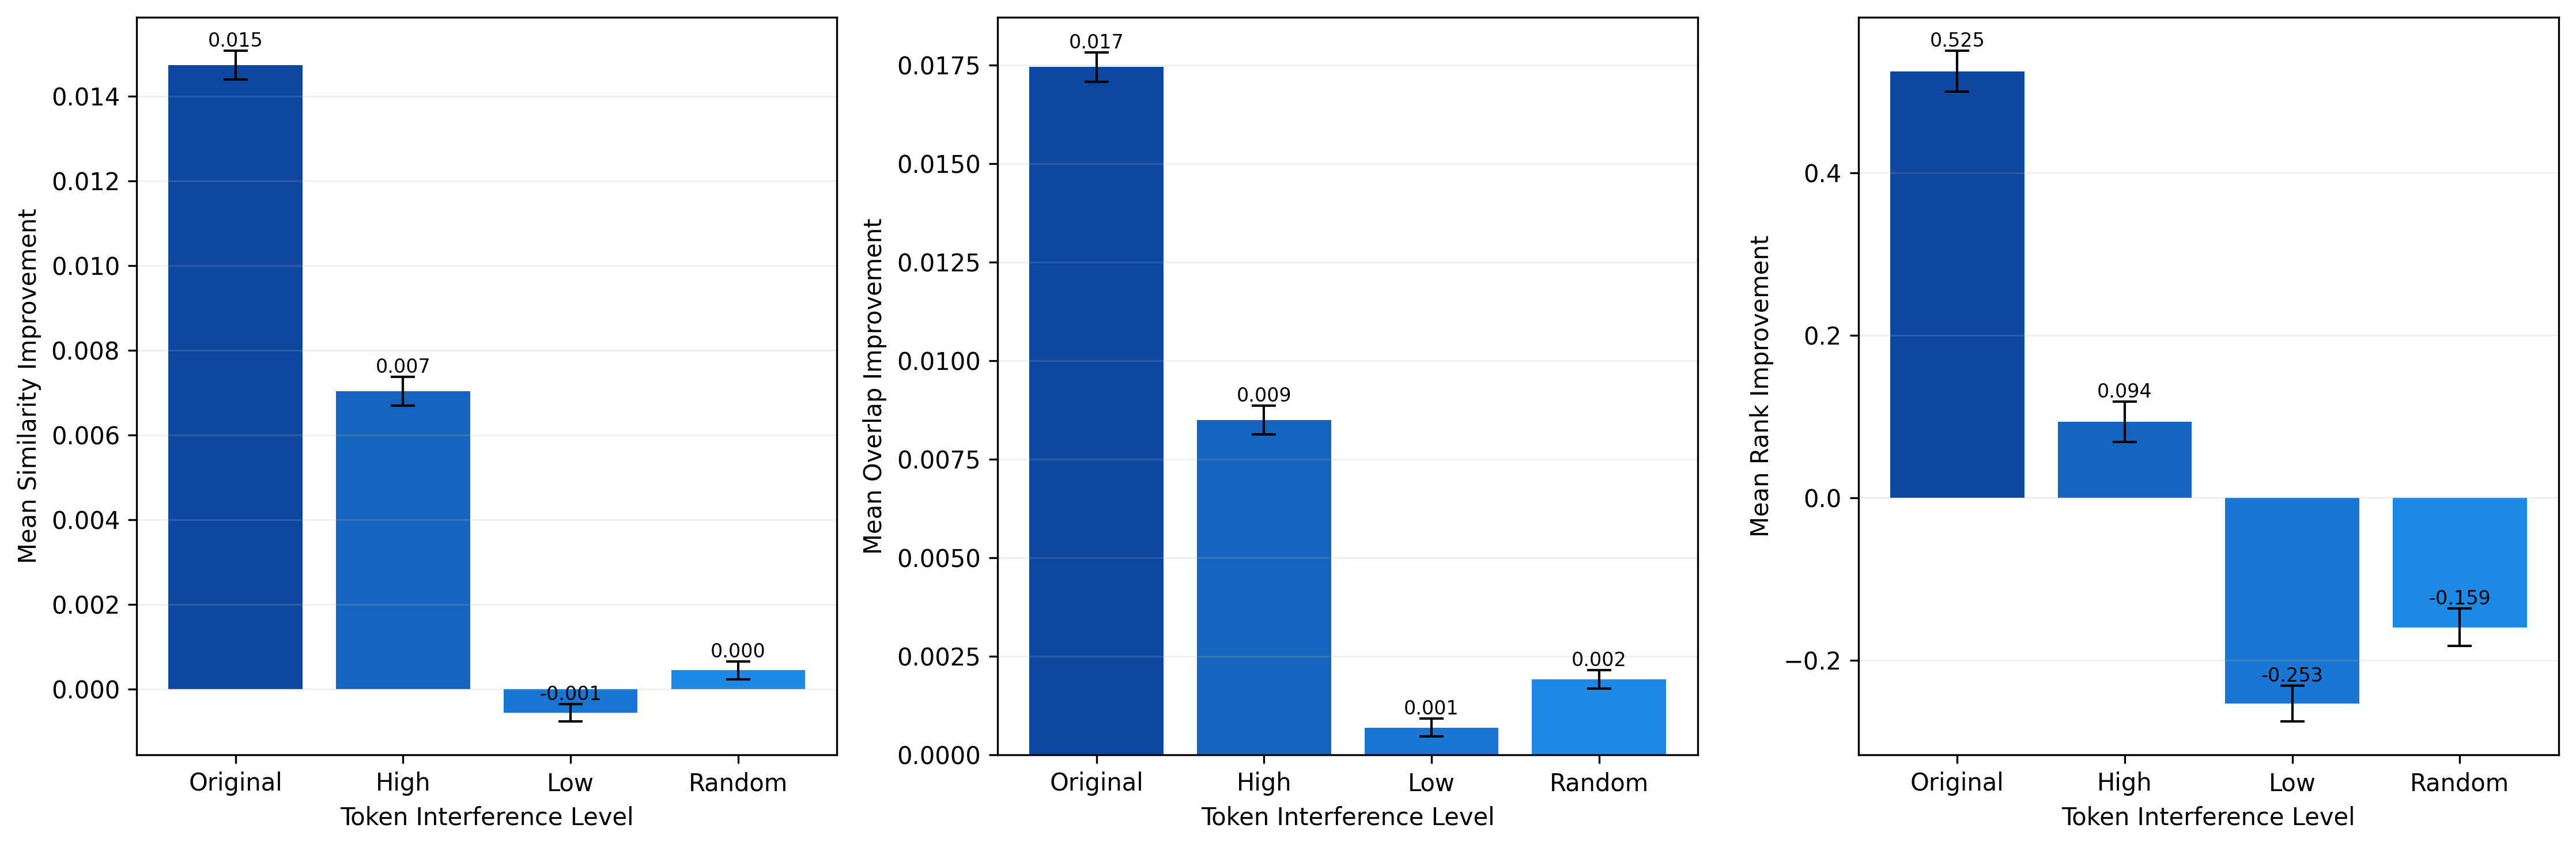

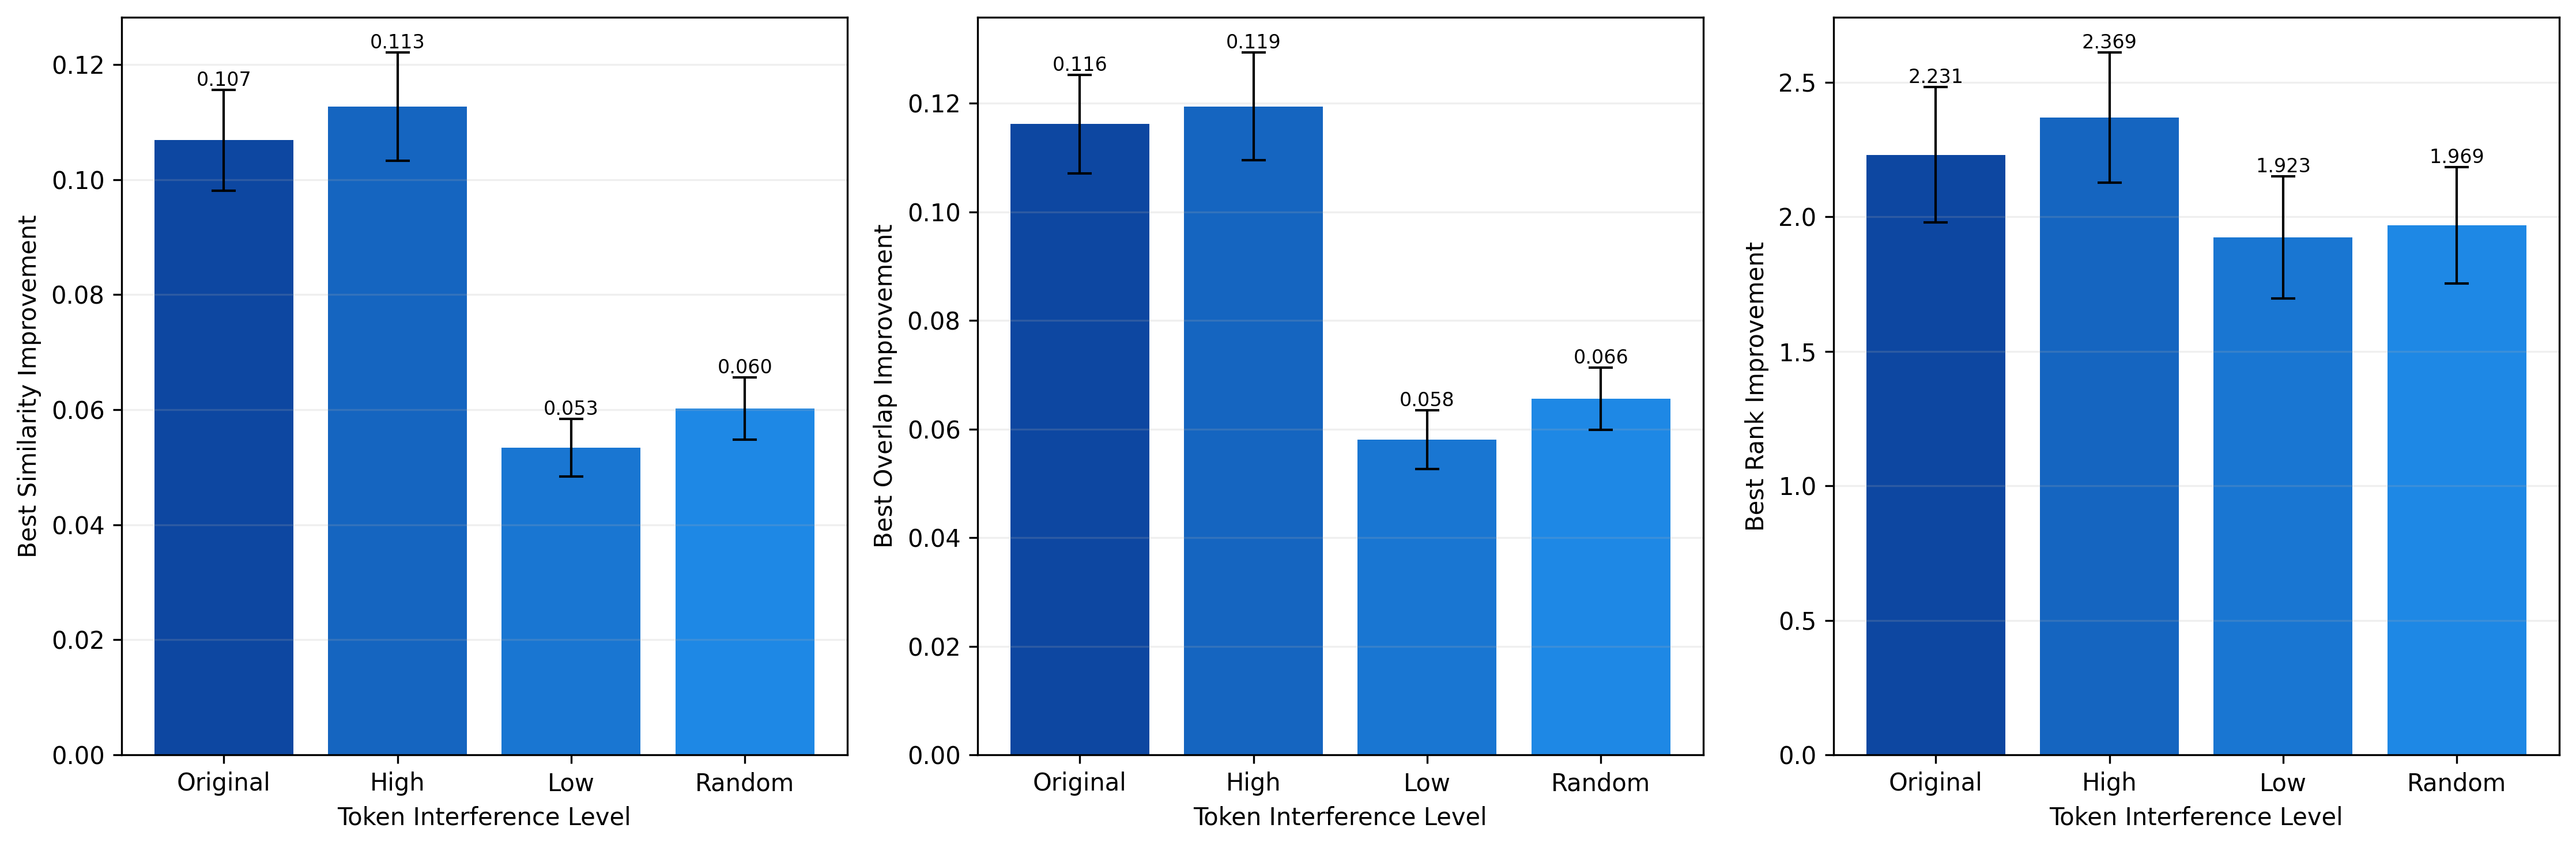

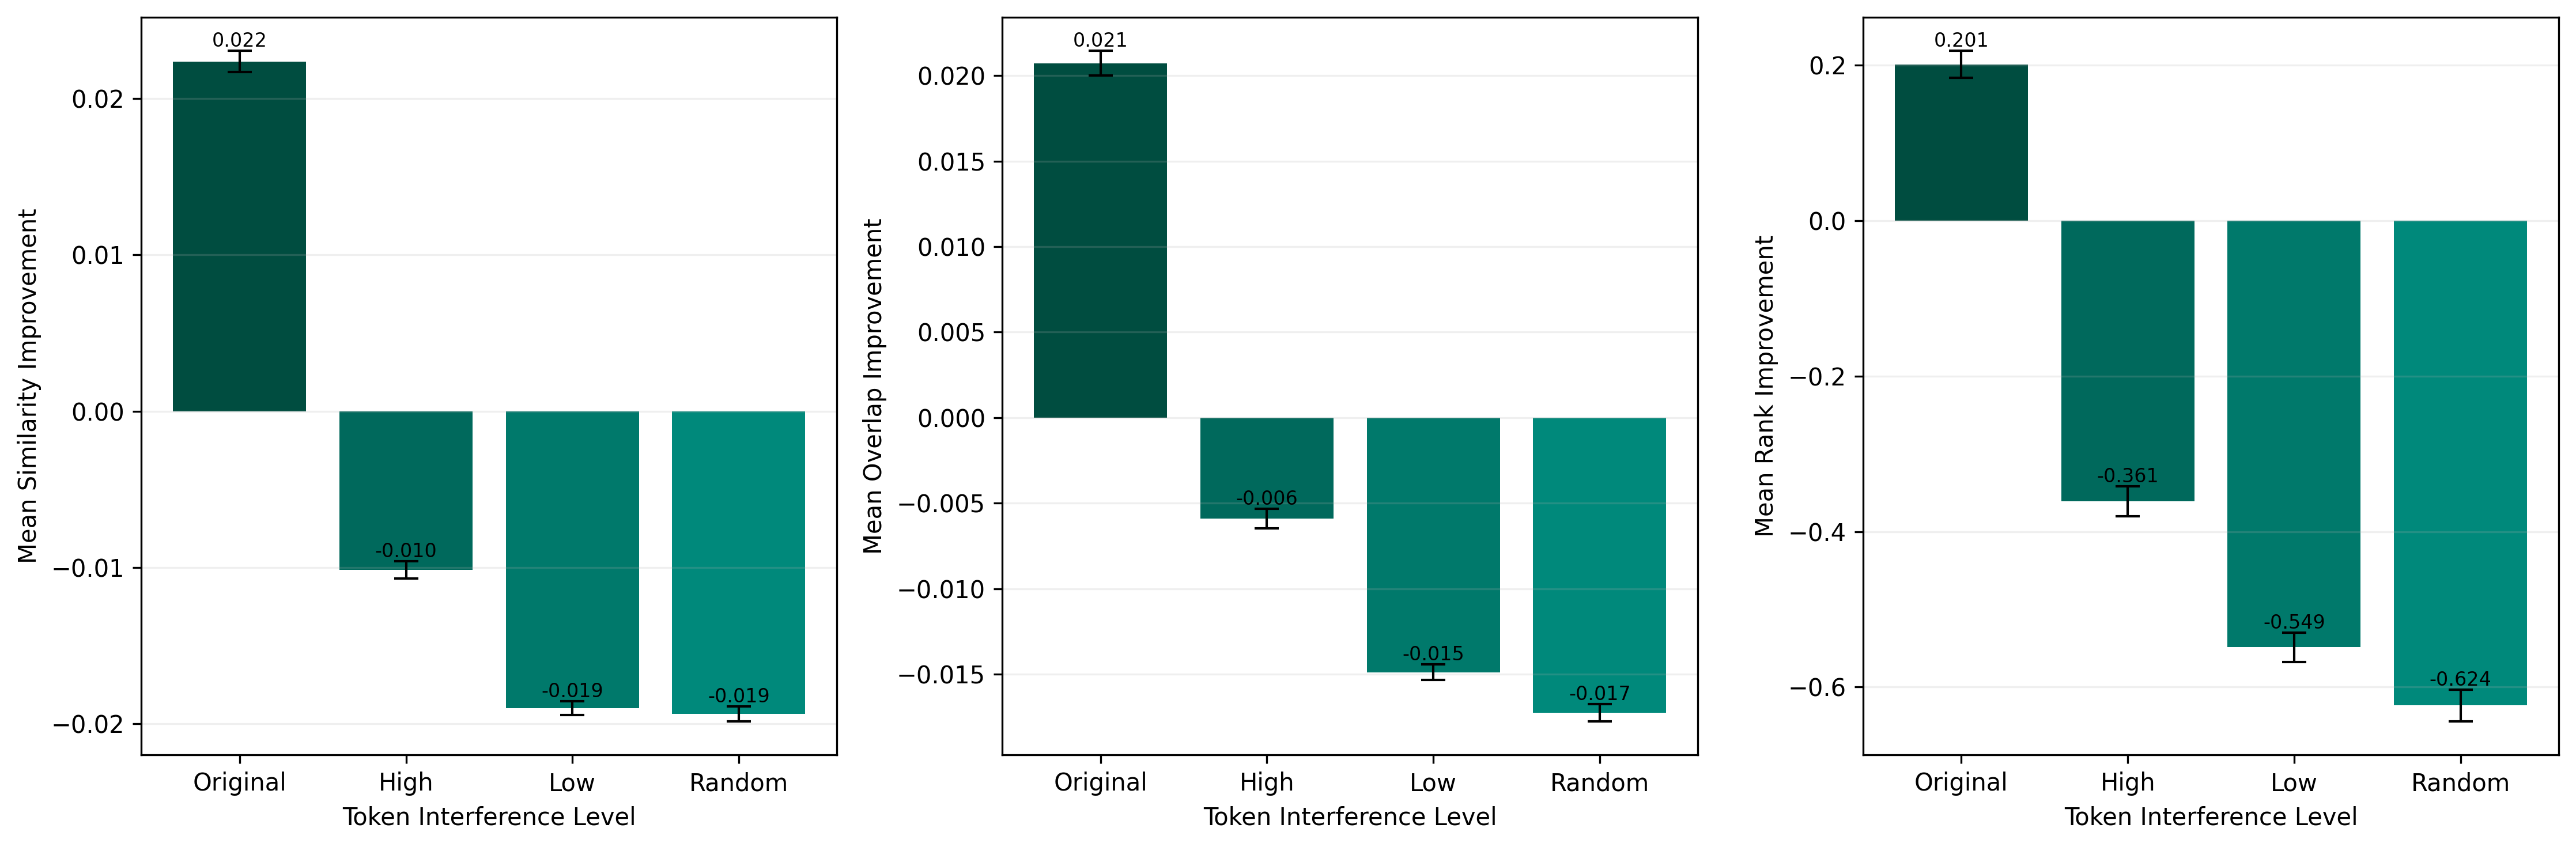

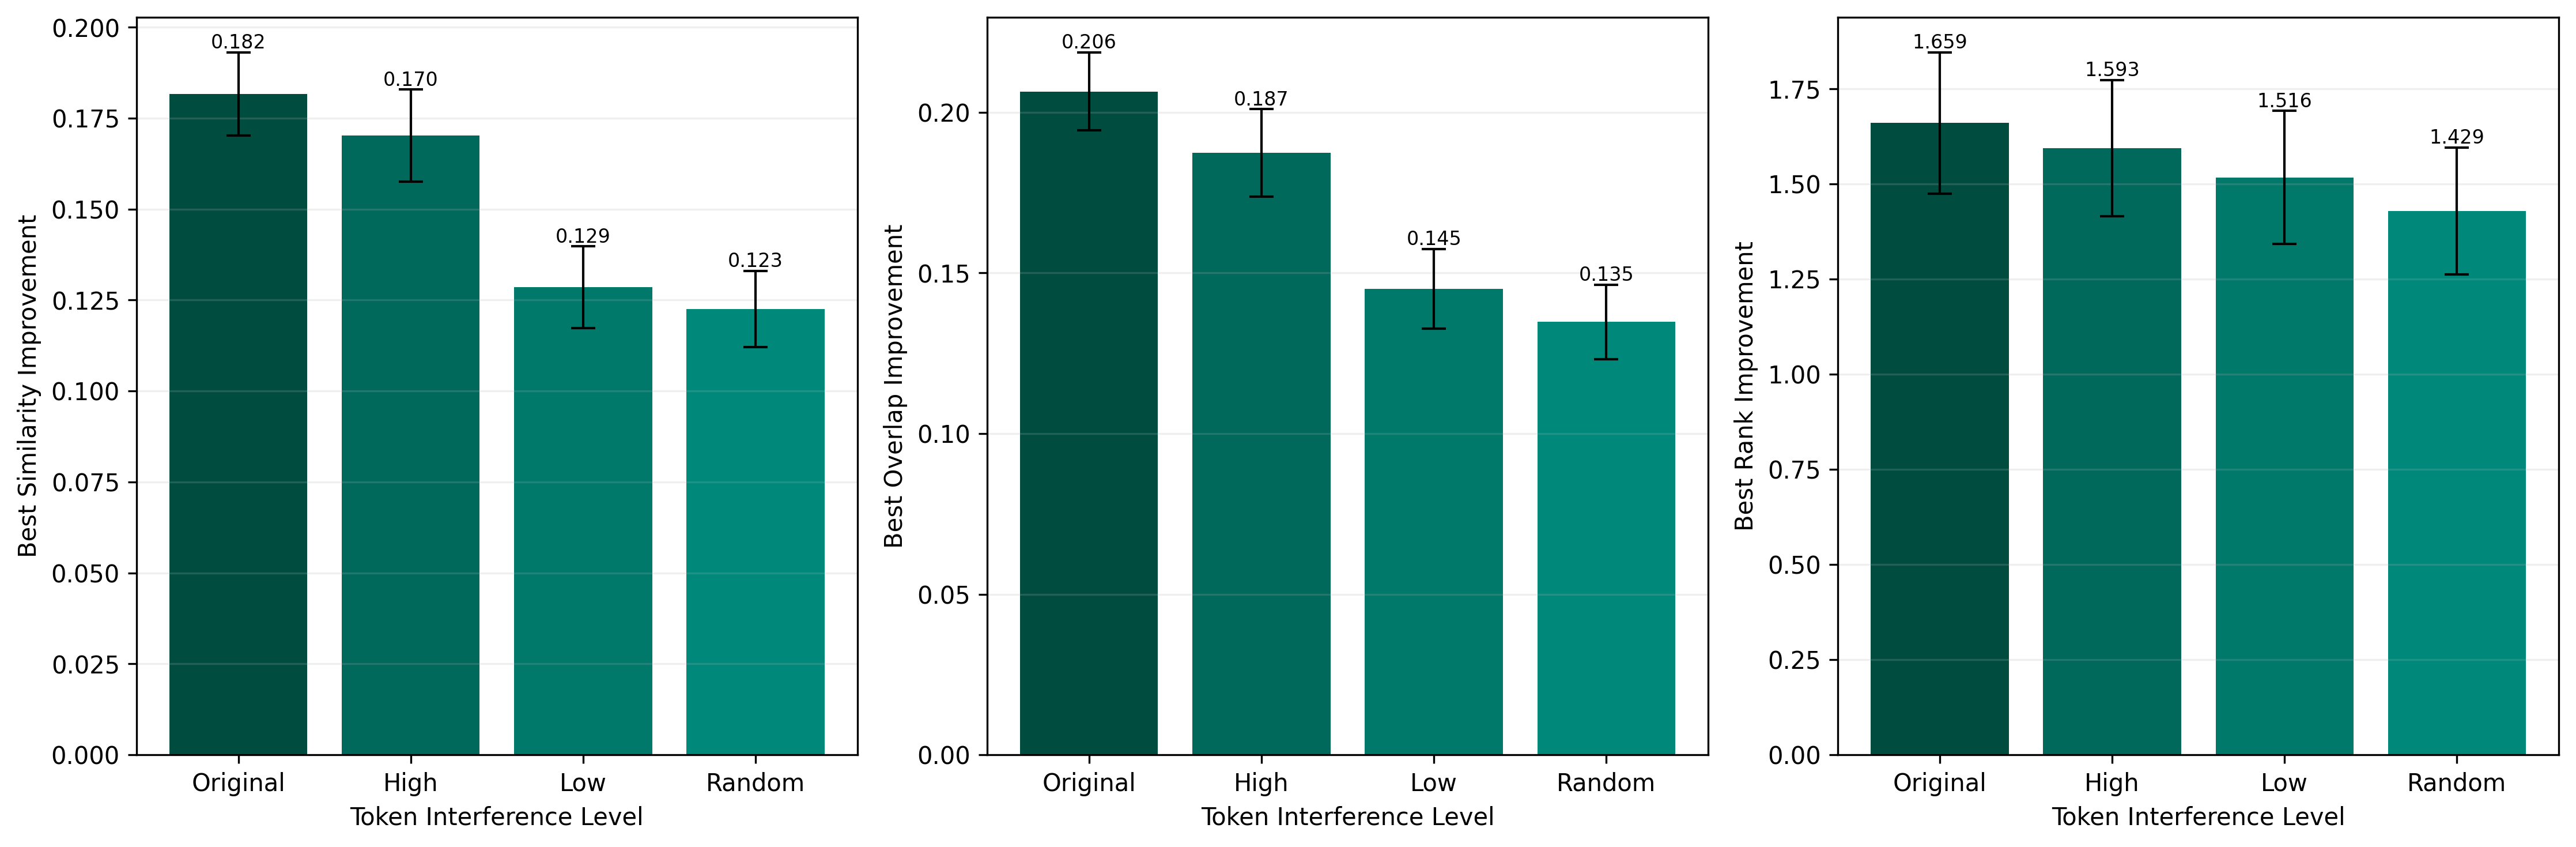

In [18]:
# Analyze results
print("\n=== Statistical Analysis ===")
compare_all_groups(pythia_results, 'location', "Pythia")
print_experiment_results(pythia_results, "Pythia", "Location")
compare_all_groups(gpt2_results, 'location', "GPT-2")
print_experiment_results(gpt2_results, "GPT-2", "Location")

# plot metics
plot_injection_metrics(pythia_results, "Pythia", "Location")
plot_best_improvements(pythia_results, "Pythia", "Location")
plot_injection_metrics(gpt2_results, "GPT-2", "Location")
plot_best_improvements(gpt2_results, "GPT-2", "Location")

### Name Prompt Injection

In [7]:
# Load interference data
with open('./corpus/pythia_non_name_interference.json', 'r') as f:
    pythia_non_name_interference = json.load(f)
with open('./corpus/gpt2_non_name_interference.json', 'r') as f:
    gpt2_non_name_interference = json.load(f)

# Get name token strings and ids
pythia_name_strs = []
pythia_name_ids = []
for token_str, token_type in tqdm(pythia_token_str_type.items()):
    if token_type == 'person':
        pythia_name_strs.append(token_str)
        token_id = pythia.to_tokens(token_str, prepend_bos=False)[0]
        if len(token_id) == 1:
            pythia_name_ids.append(token_id.item())
        else:
            pythia_name_ids.append(token_id[0].item())

gpt2_name_strs = []
gpt2_name_ids = []
for token_str, token_type in tqdm(gpt2_token_str_type.items()):
    if token_type == 'person':
        gpt2_name_strs.append(token_str)
        token_id = gpt2.to_tokens(token_str, prepend_bos=False)[0]
        if len(token_id) == 1:
            gpt2_name_ids.append(token_id.item())
        else:
            gpt2_name_ids.append(token_id[0].item())

# Get high/medium interference tokens for name
pythia_name_high_interference_tokens = set()
pythia_name_low_interference_tokens = set()
for layer_type, layer_type_data in pythia_non_name_interference.items():
    for layer_id, interference_pairs in layer_type_data.items():
        for interference_pair in interference_pairs:
            if interference_pair['interference_value'] > 0.5:
                pythia_name_high_interference_tokens.add(interference_pair['interfering_token'])
            elif interference_pair['interference_value'] > 0.2:
                pythia_name_low_interference_tokens.add(interference_pair['interfering_token'])

gpt2_name_high_interference_tokens = set()
gpt2_name_low_interference_tokens = set()
for layer_type, layer_type_data in gpt2_non_name_interference.items():
    for layer_id, interference_pairs in layer_type_data.items():
        for interference_pair in interference_pairs:
            if interference_pair['interference_value'] > 0.5:
                gpt2_name_high_interference_tokens.add(interference_pair['interfering_token'])
            elif interference_pair['interference_value'] > 0.2:
                gpt2_name_low_interference_tokens.add(interference_pair['interfering_token'])

# Convert sets to lists for later use
pythia_name_high_interference_tokens = list(pythia_name_high_interference_tokens)
pythia_name_low_interference_tokens = list(pythia_name_low_interference_tokens)
gpt2_name_high_interference_tokens = list(gpt2_name_high_interference_tokens)
gpt2_name_low_interference_tokens = list(gpt2_name_low_interference_tokens)

# Get random tokens
pythia_name_random_tokens = []
gpt2_name_random_tokens = []
for token_str in pythia_token_str_type.keys():
    if (token_str not in pythia_name_strs and 
        token_str not in pythia_name_high_interference_tokens and 
        token_str not in pythia_name_low_interference_tokens):
        pythia_name_random_tokens.append(token_str)
for token_str in gpt2_token_str_type.keys():
    if (token_str not in gpt2_name_strs and 
        token_str not in gpt2_name_high_interference_tokens and 
        token_str not in gpt2_name_low_interference_tokens):
        gpt2_name_random_tokens.append(token_str)

# Print statistics
print("=== Name Experiment Configuration ===")
print("Pythia Model:")
print(f"Name tokens: {len(pythia_name_strs)}")
print(f"High Interference Tokens (>0.5): {len(pythia_name_high_interference_tokens)}")
print(f"Mid Interference Tokens (0.2-0.5): {len(pythia_name_low_interference_tokens)}")
print(f"Random Tokens: {len(pythia_name_random_tokens)}")

print("\nGPT-2 Model:")
print(f"Name tokens: {len(gpt2_name_strs)}")
print(f"High Interference Tokens (>0.5): {len(gpt2_name_high_interference_tokens)}")
print(f"Mid Interference Tokens (0.2-0.5): {len(gpt2_name_low_interference_tokens)}")
print(f"Random Tokens: {len(gpt2_name_random_tokens)}")

  0%|          | 0/49069 [00:00<?, ?it/s]

  0%|          | 0/49727 [00:00<?, ?it/s]

=== Name Experiment Configuration ===
Pythia Model:
Name tokens: 2650
High Interference Tokens (>0.5): 2418
Mid Interference Tokens (0.2-0.5): 22179
Random Tokens: 25030

GPT-2 Model:
Name tokens: 4024
High Interference Tokens (>0.5): 2008
Mid Interference Tokens (0.2-0.5): 34870
Random Tokens: 11382


In [8]:
# Run name experiments for Pythia
random.seed(42)
n_trials = 100
token_types = ['target', 'high_interference', 'medium_interference', 'random']

print("\n=== Running Pythia Name Experiments ===")
pythia_name_results = {token_type: [] for token_type in token_types}

for sentence in tqdm(name_sentences[:100]):
    torch.cuda.empty_cache()
    
    # Target (name) tokens test
    target_results = run_injection_experiment(
        pythia, sentence, pythia_name_strs,
        n_trials, pythia_name_ids
    )
    pythia_name_results['target'].append({
        'sentence': sentence,
        'results': target_results
    })
    
    # High interference tokens test
    high_results = run_injection_experiment(
        pythia, sentence, pythia_name_high_interference_tokens,
        n_trials, pythia_name_ids
    )
    pythia_name_results['high_interference'].append({
        'sentence': sentence,
        'results': high_results
    })
    
    # Medium interference tokens test
    med_results = run_injection_experiment(
        pythia, sentence, pythia_name_low_interference_tokens,
        n_trials, pythia_name_ids
    )
    pythia_name_results['medium_interference'].append({
        'sentence': sentence,
        'results': med_results
    })
    
    # Random tokens test
    rand_results = run_injection_experiment(
        pythia, sentence, pythia_name_random_tokens,
        n_trials, pythia_name_ids
    )
    pythia_name_results['random'].append({
        'sentence': sentence,
        'results': rand_results
    })

# Run name experiments for GPT-2
print("\n=== Running GPT-2 Name Experiments ===")
gpt2_name_results = {token_type: [] for token_type in token_types}

for sentence in tqdm(name_sentences[:100]):
    torch.cuda.empty_cache()
    
    # Target (name) tokens test
    target_results = run_injection_experiment(
        gpt2, sentence, gpt2_name_strs,
        n_trials, gpt2_name_ids
    )
    gpt2_name_results['target'].append({
        'sentence': sentence,
        'results': target_results
    })
    
    # High interference tokens test
    high_results = run_injection_experiment(
        gpt2, sentence, gpt2_name_high_interference_tokens,
        n_trials, gpt2_name_ids
    )
    gpt2_name_results['high_interference'].append({
        'sentence': sentence,
        'results': high_results
    })
    
    # Medium interference tokens test
    med_results = run_injection_experiment(
        gpt2, sentence, gpt2_name_low_interference_tokens,
        n_trials, gpt2_name_ids
    )
    gpt2_name_results['medium_interference'].append({
        'sentence': sentence,
        'results': med_results
    })
    
    # Random tokens test
    rand_results = run_injection_experiment(
        gpt2, sentence, gpt2_name_random_tokens,
        n_trials, gpt2_name_ids
    )
    gpt2_name_results['random'].append({
        'sentence': sentence,
        'results': rand_results
    })


=== Running Pythia Name Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Running GPT-2 Name Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Name Statistical Analysis ===

=== Pythia name Statistical Analysis ===

Target vs Random:
Difference: 0.0961
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

High Interference vs Random:
Difference: -0.0144
p-value: 0.0058
Statistical significance: difference is significant (p = 0.0058)

Medium Interference vs Random:
Difference: -0.0082
p-value: 0.1189
Statistical significance: difference is not significant (p = 0.1189)

=== Pythia Name Experiment Results ===

target:
Top-10 token count increase rate: 26.59% (2659/10000)
Top-10 token probability sum increase rate: 34.83% (3483/10000)

high_interference:
Top-10 token count increase rate: 15.54% (1554/10000)
Top-10 token probability sum increase rate: 22.96% (2296/10000)

medium_interference:
Top-10 token count increase rate: 16.16% (1616/10000)
Top-10 token probability sum increase rate: 23.54% (2354/10000)

random:
Top-10 token count increase rate: 16.98% (1698/10000)
Top-10 token probability sum

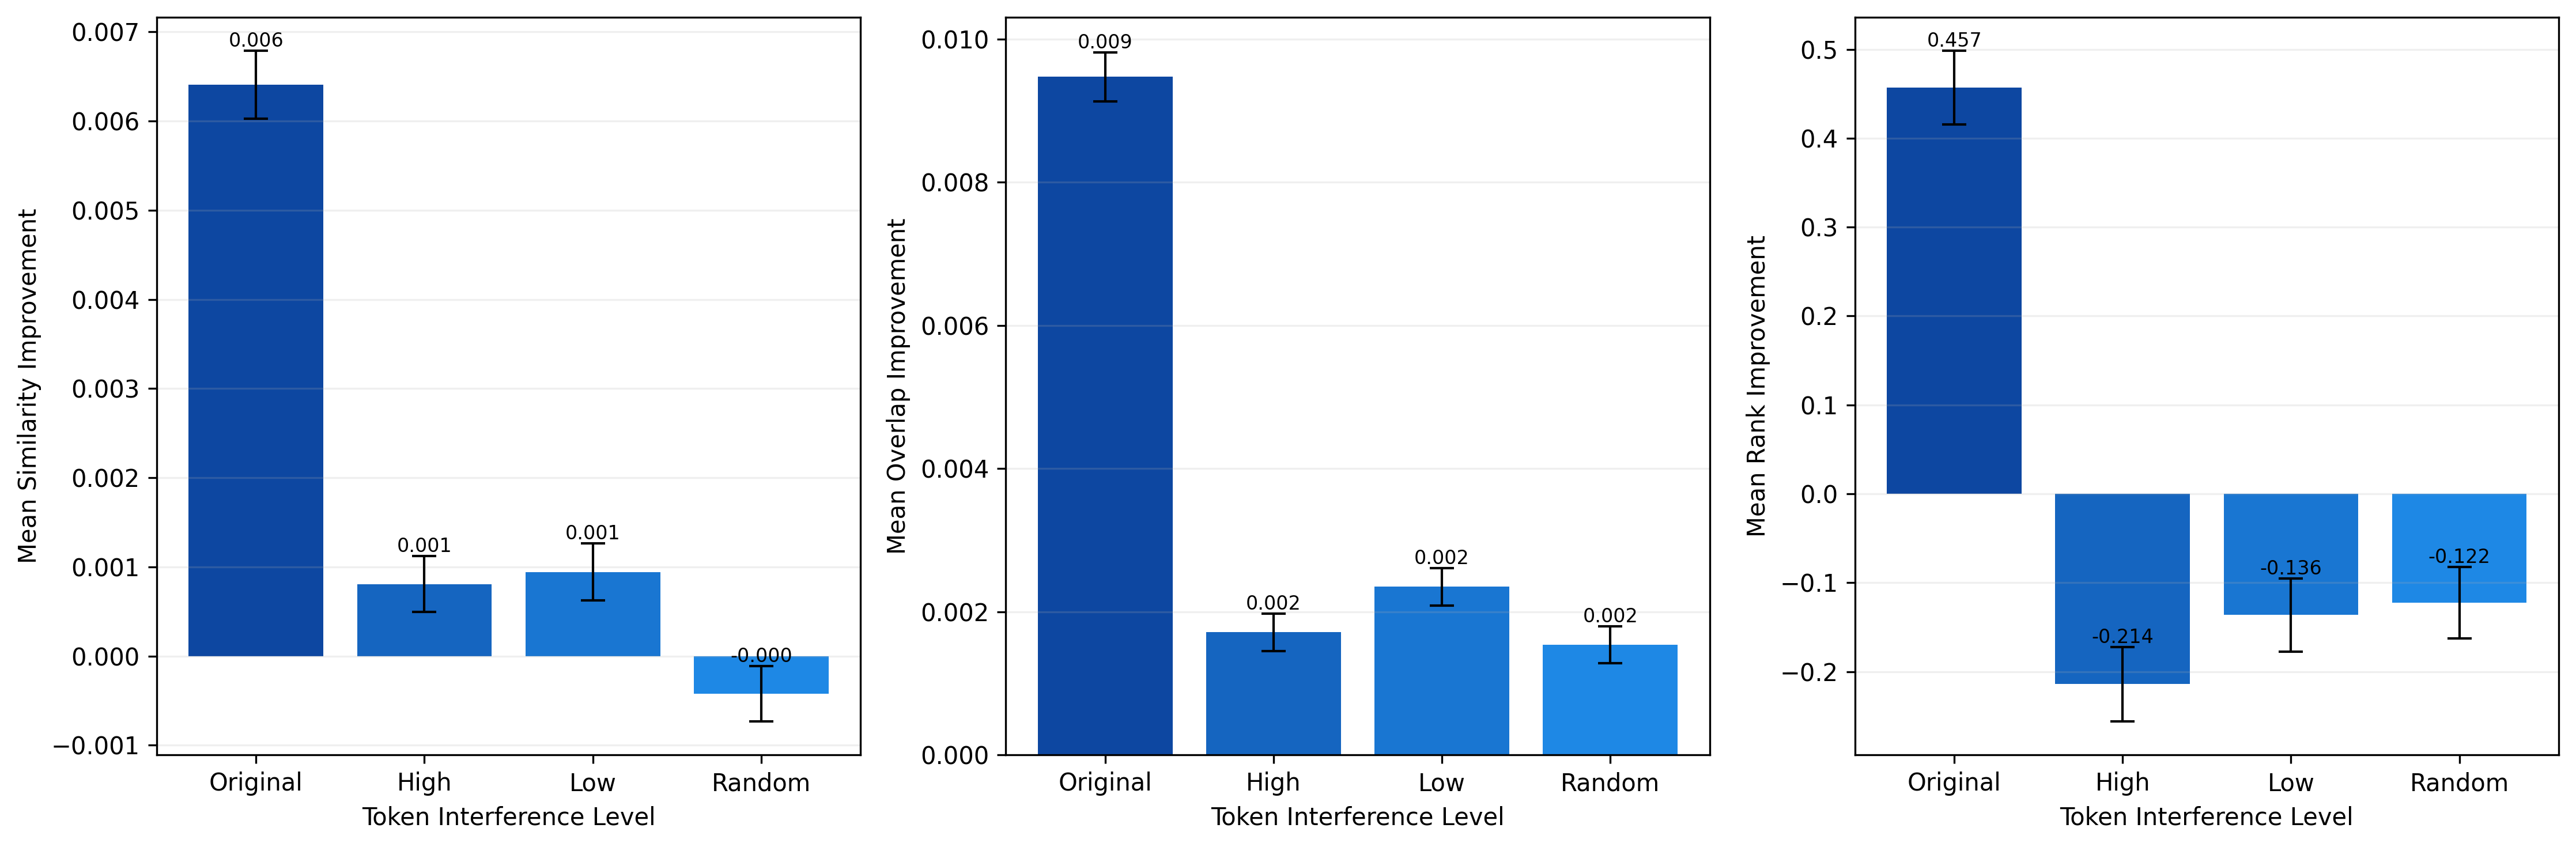

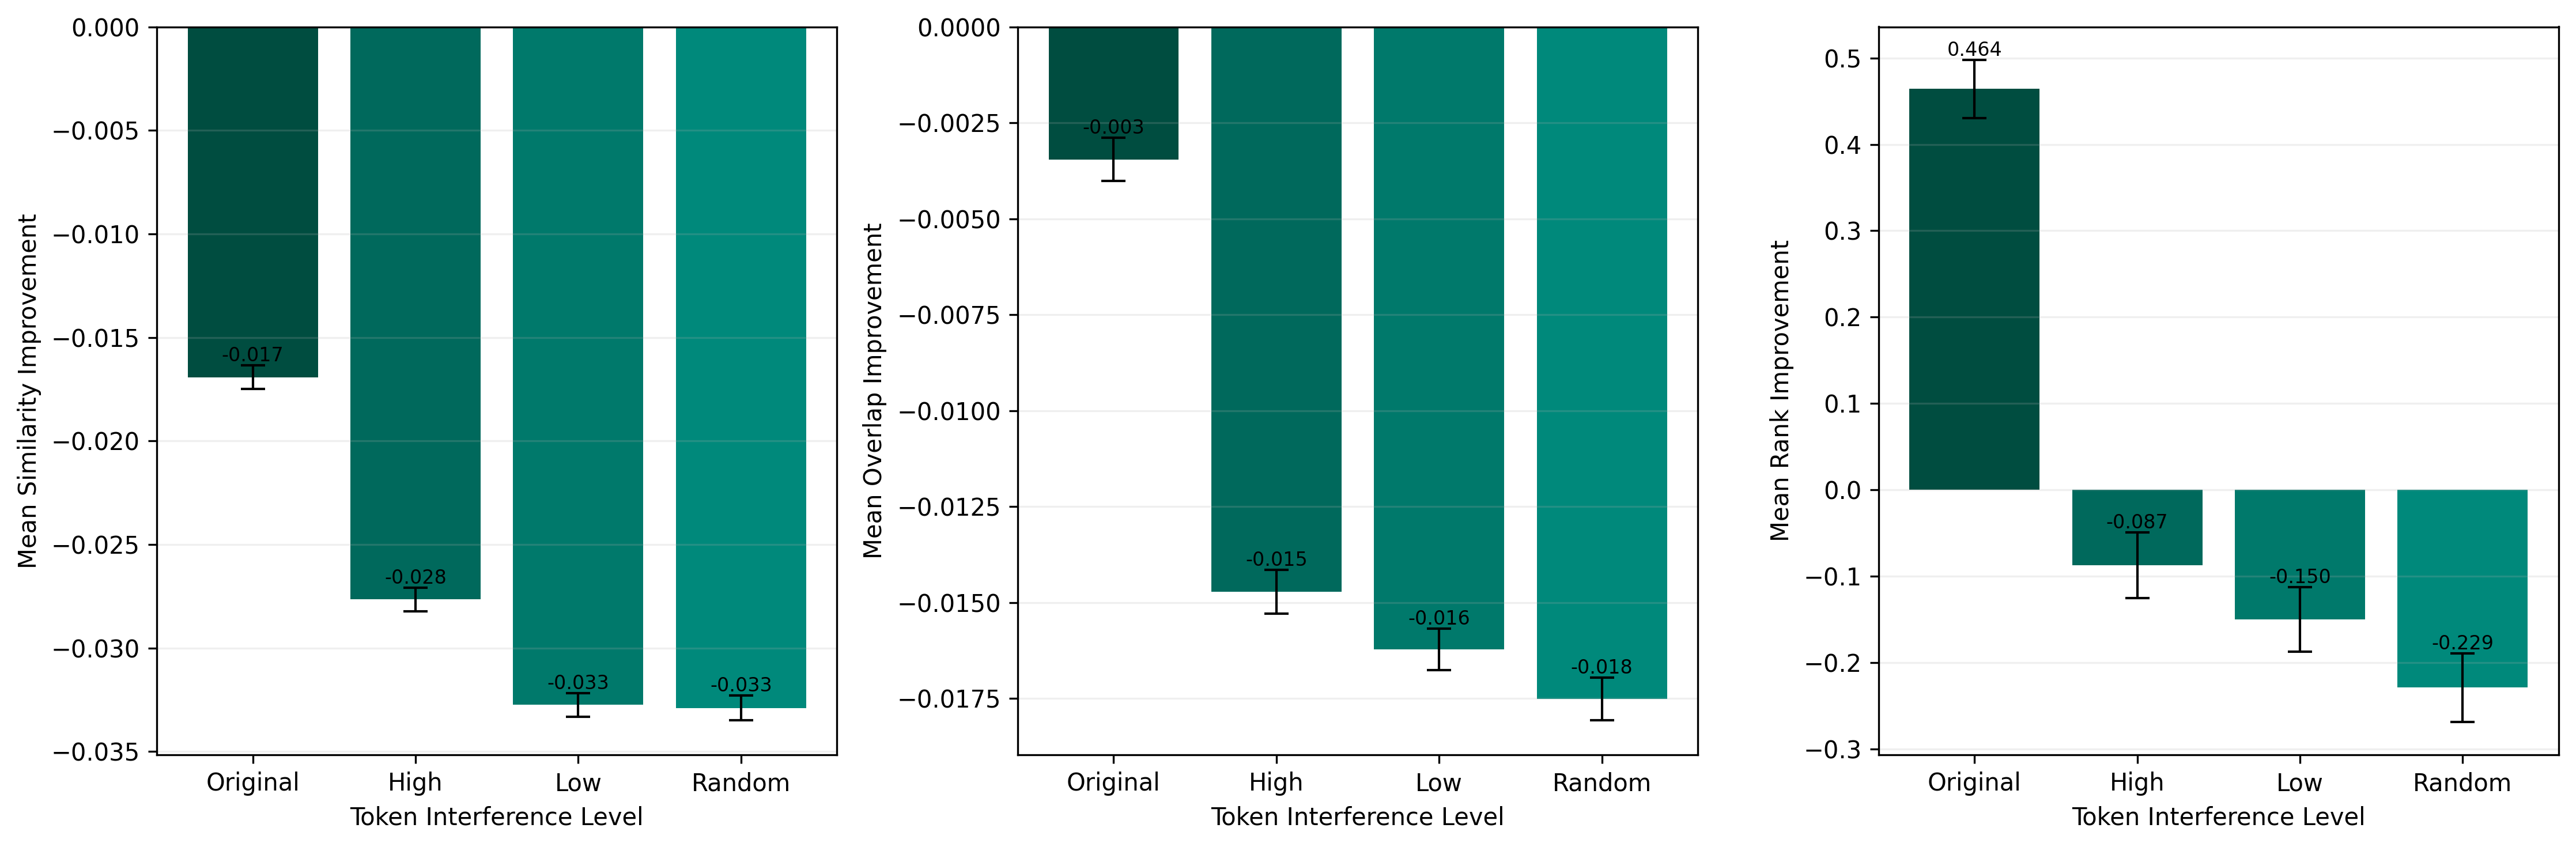

In [ ]:
# Analyze results
print("\n=== Name Statistical Analysis ===")
compare_all_groups(pythia_name_results, 'name', "Pythia")
print_experiment_results(pythia_name_results, "Pythia", "Name")
compare_all_groups(gpt2_name_results, 'name', "GPT-2")
print_experiment_results(gpt2_name_results, "GPT-2", "Name")

# Plot name experiment results
plot_injection_metrics(pythia_name_results, "Pythia", "Name")
plot_best_improvements(pythia_name_results, "Pythia", "Name")
plot_injection_metrics(gpt2_name_results, "GPT-2", "Name")
plot_best_improvements(gpt2_name_results, "GPT-2", "Name")

### Love & Hate Prompt Injection

In [ ]:
# Load love & hate interference data
with open('./corpus/pythia_non_love_interference.json', 'r') as f:
    pythia_non_love_interference = json.load(f)
with open('./corpus/gpt2_non_love_interference.json', 'r') as f:
    gpt2_non_love_interference = json.load(f)

# love hate related tokens
love_hate_tokens = [
    ' hate', ' hated', ' hates', ' dislike', ' love', ' hatred', 
    ' loved', ' disdain', ' LOVE', 'love', ' disrespect', 'Love', 
    ' Love', 'liked', ' loves', ' scorn', ' anger', ' liked', ' like',
    ' hostility', ' liking', ' resentment', ' kill', ' resent', 
    ' outrage', 'ophobia'
]

# Get love hate token ids
pythia_love_hate_ids = []
for token_str in love_hate_tokens:
    token_id = pythia.to_tokens(token_str, prepend_bos=False)[0]
    if len(token_id) == 1:
        pythia_love_hate_ids.append(token_id.item())
    else:
        pythia_love_hate_ids.append(token_id[0].item())

gpt2_love_hate_ids = []
for token_str in love_hate_tokens:
    token_id = gpt2.to_tokens(token_str, prepend_bos=False)[0]
    if len(token_id) == 1:
        gpt2_love_hate_ids.append(token_id.item())
    else:
        gpt2_love_hate_ids.append(token_id[0].item())

# Get high/medium interference tokens
pythia_love_high_interference_tokens = set()
pythia_love_low_interference_tokens = set()
for layer_type, layer_type_data in tqdm(pythia_non_love_interference.items()):
    for layer_id, interference_pairs in layer_type_data.items():
        for interference_pair in interference_pairs:
            if interference_pair['interference_value'] > 0.5:
                pythia_love_high_interference_tokens.add(interference_pair['interfering_token'])
            elif interference_pair['interference_value'] > 0.2:
                pythia_love_low_interference_tokens.add(interference_pair['interfering_token'])

gpt2_love_high_interference_tokens = set()
gpt2_love_low_interference_tokens = set()
for layer_type, layer_type_data in tqdm(gpt2_non_love_interference.items()):
    for layer_id, interference_pairs in layer_type_data.items():
        for interference_pair in interference_pairs:
            if interference_pair['interference_value'] > 0.5:
                gpt2_love_high_interference_tokens.add(interference_pair['interfering_token'])
            elif interference_pair['interference_value'] > 0.2:
                gpt2_love_low_interference_tokens.add(interference_pair['interfering_token'])

# Convert sets to lists
pythia_love_high_interference_tokens = list(pythia_love_high_interference_tokens)
pythia_love_low_interference_tokens = list(pythia_love_low_interference_tokens)
gpt2_love_high_interference_tokens = list(gpt2_love_high_interference_tokens)
gpt2_love_low_interference_tokens = list(gpt2_love_low_interference_tokens)

# Get random tokens
pythia_love_random_tokens = []
for token_str in tqdm(pythia_token_str_type.keys()):
    if (token_str not in love_hate_tokens and 
        token_str not in pythia_love_high_interference_tokens and 
        token_str not in pythia_love_low_interference_tokens):
        pythia_love_random_tokens.append(token_str)

gpt2_love_random_tokens = []
for token_str in tqdm(gpt2_token_str_type.keys()):
    if (token_str not in love_hate_tokens and 
        token_str not in gpt2_love_high_interference_tokens and 
        token_str not in gpt2_love_low_interference_tokens):
        gpt2_love_random_tokens.append(token_str)

# Print statistics
print("\n=== Love&Hate Experiment Configuration ===")
print("Pythia Model:")
print(f"Love/Hate tokens: {len(love_hate_tokens)}")
print(f"High Interference Tokens (>0.5): {len(pythia_love_high_interference_tokens)}")
print(f"Mid Interference Tokens (0.2-0.5): {len(pythia_love_low_interference_tokens)}")
print(f"Random Tokens: {len(pythia_love_random_tokens)}")

print("\nGPT-2 Model:")
print(f"Love/Hate tokens: {len(love_hate_tokens)}")
print(f"High Interference Tokens (>0.5): {len(gpt2_love_high_interference_tokens)}")
print(f"Mid Interference Tokens (0.2-0.5): {len(gpt2_love_low_interference_tokens)}")
print(f"Random Tokens: {len(gpt2_love_random_tokens)}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/49069 [00:00<?, ?it/s]

  0%|          | 0/49727 [00:00<?, ?it/s]


=== Love&Hate Experiment Configuration ===
Pythia Model:
Love/Hate tokens: 26
High Interference Tokens (>0.5): 205
Mid Interference Tokens (0.2-0.5): 10486
Random Tokens: 38714

GPT-2 Model:
Love/Hate tokens: 26
High Interference Tokens (>0.5): 394
Mid Interference Tokens (0.2-0.5): 18471
Random Tokens: 31499


In [11]:
# Run love hate experiments for Pythia
random.seed(47)
n_trials = 100
token_types = ['target', 'high_interference', 'medium_interference', 'random']

print("\n=== Running Pythia Love&Hate Experiments ===")
pythia_love_hate_results = {token_type: [] for token_type in token_types}

for sentence in tqdm(love_hate_sentences[:100]):
    torch.cuda.empty_cache()
    
    # Target (love hate) tokens test
    target_results = run_injection_experiment(
        pythia, sentence, love_hate_tokens,
        n_trials, pythia_love_hate_ids
    )
    pythia_love_hate_results['target'].append({
        'sentence': sentence,
        'results': target_results
    })
    
    # High interference tokens test
    high_results = run_injection_experiment(
        pythia, sentence, pythia_love_high_interference_tokens,
        n_trials, pythia_love_hate_ids
    )
    pythia_love_hate_results['high_interference'].append({
        'sentence': sentence,
        'results': high_results
    })
    
    # Medium interference tokens test
    med_results = run_injection_experiment(
        pythia, sentence, pythia_love_low_interference_tokens,
        n_trials, pythia_love_hate_ids
    )
    pythia_love_hate_results['medium_interference'].append({
        'sentence': sentence,
        'results': med_results
    })
    
    # Random tokens test
    rand_results = run_injection_experiment(
        pythia, sentence, pythia_love_random_tokens,
        n_trials, pythia_love_hate_ids
    )
    pythia_love_hate_results['random'].append({
        'sentence': sentence,
        'results': rand_results
    })

# Run love hate experiments for GPT-2
print("\n=== Running GPT-2 Love&Hate Experiments ===")
gpt2_love_hate_results = {token_type: [] for token_type in token_types}

for sentence in tqdm(love_hate_sentences[:100]):
    torch.cuda.empty_cache()
    
    # Target (love hate) tokens test
    target_results = run_injection_experiment(
        gpt2, sentence, love_hate_tokens,
        n_trials, gpt2_love_hate_ids
    )
    gpt2_love_hate_results['target'].append({
        'sentence': sentence,
        'results': target_results
    })
    
    # High interference tokens test
    high_results = run_injection_experiment(
        gpt2, sentence, gpt2_love_high_interference_tokens,
        n_trials, gpt2_love_hate_ids
    )
    gpt2_love_hate_results['high_interference'].append({
        'sentence': sentence,
        'results': high_results
    })
    
    # Medium interference tokens test
    med_results = run_injection_experiment(
        gpt2, sentence, gpt2_love_low_interference_tokens,
        n_trials, gpt2_love_hate_ids
    )
    gpt2_love_hate_results['medium_interference'].append({
        'sentence': sentence,
        'results': med_results
    })
    
    # Random tokens test
    rand_results = run_injection_experiment(
        gpt2, sentence, gpt2_love_random_tokens,
        n_trials, gpt2_love_hate_ids
    )
    gpt2_love_hate_results['random'].append({
        'sentence': sentence,
        'results': rand_results
    })


=== Running Pythia Love&Hate Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Running GPT-2 Love&Hate Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Love&Hate Statistical Analysis ===

=== Pythia love_hate Statistical Analysis ===

Target vs Random:
Difference: 0.2025
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

High Interference vs Random:
Difference: 0.0233
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

Medium Interference vs Random:
Difference: 0.0122
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

=== Pythia Love&Hate Experiment Results ===

target:
Top-10 token count increase rate: 23.51% (2351/10000)
Top-10 token probability sum increase rate: 25.97% (2597/10000)

high_interference:
Top-10 token count increase rate: 5.59% (559/10000)
Top-10 token probability sum increase rate: 7.64% (764/10000)

medium_interference:
Top-10 token count increase rate: 4.48% (448/10000)
Top-10 token probability sum increase rate: 6.79% (679/10000)

random:
Top-10 token count increase rate: 3.26% (326/10000)
Top-10 token probability sum 

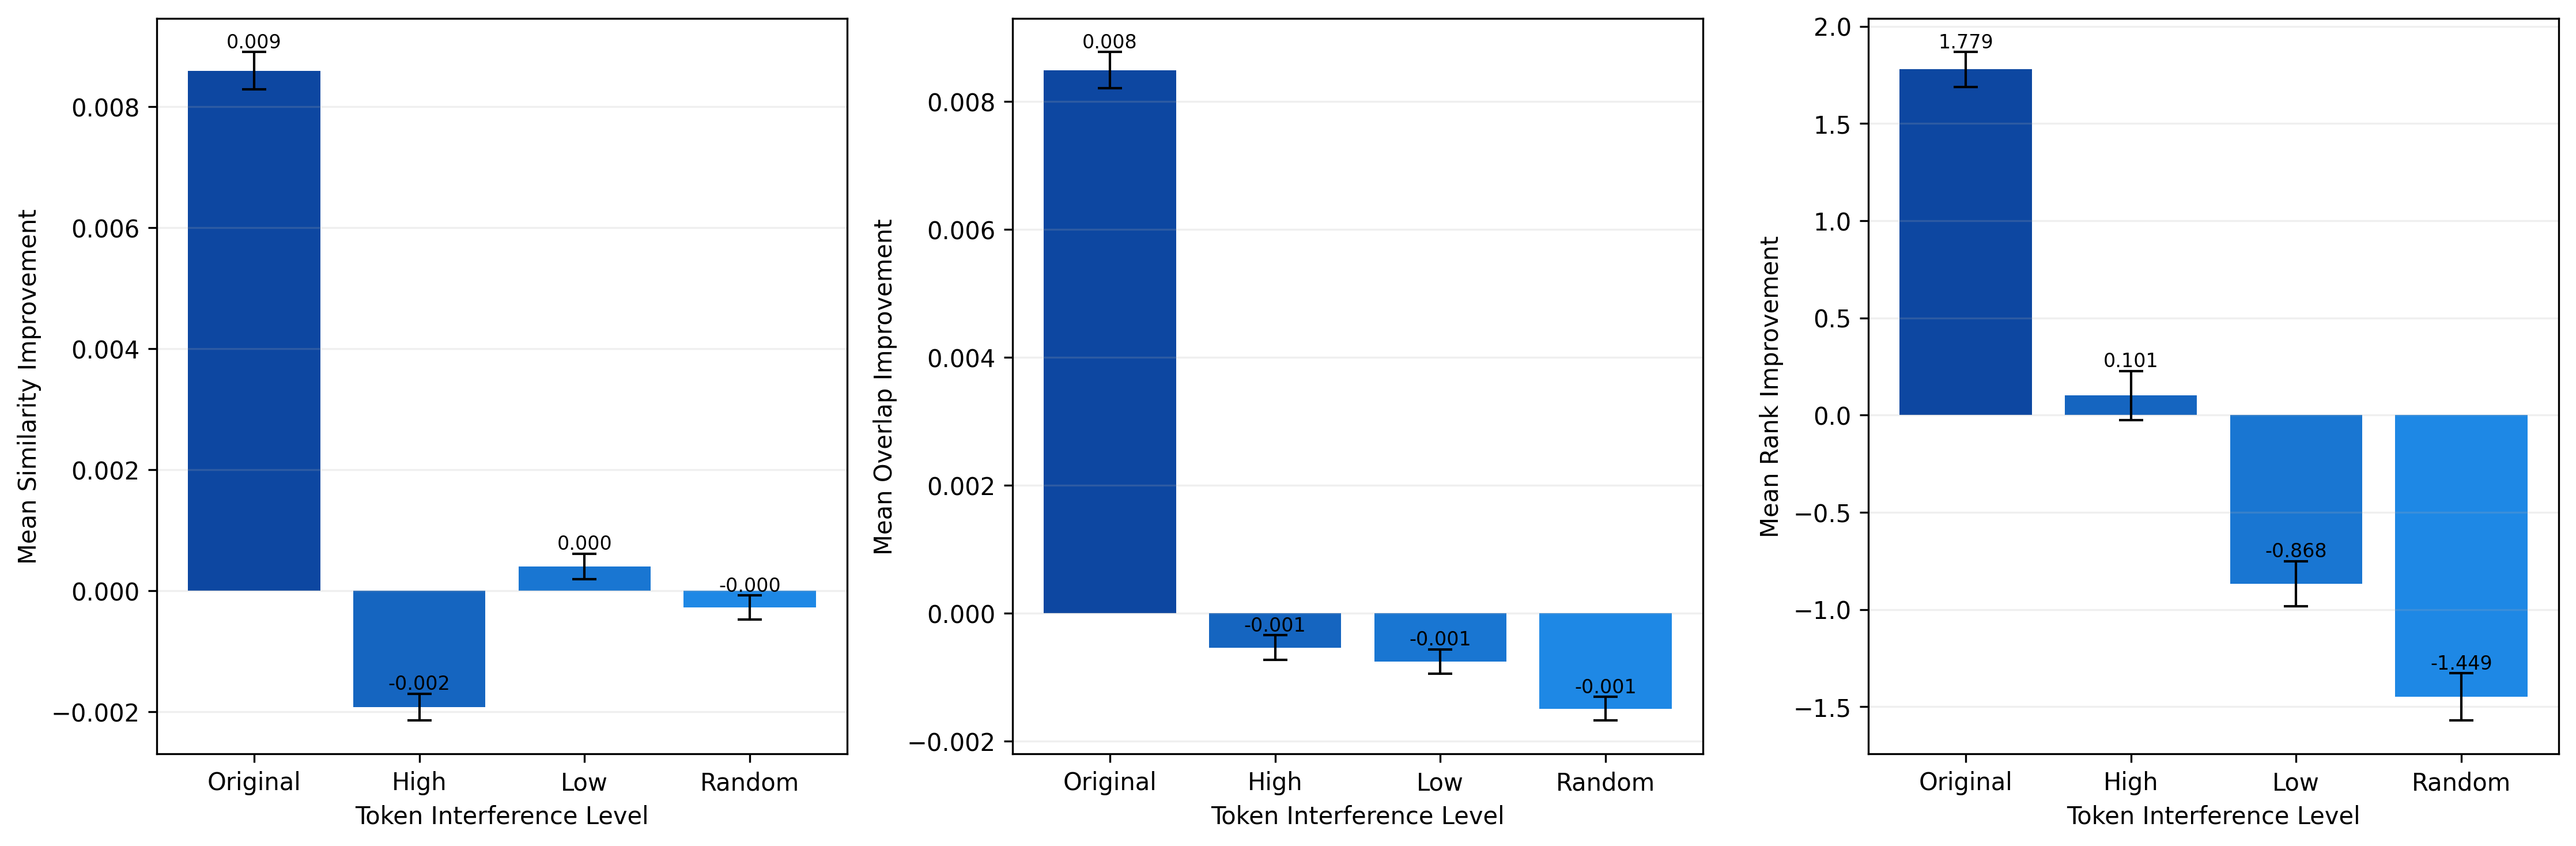

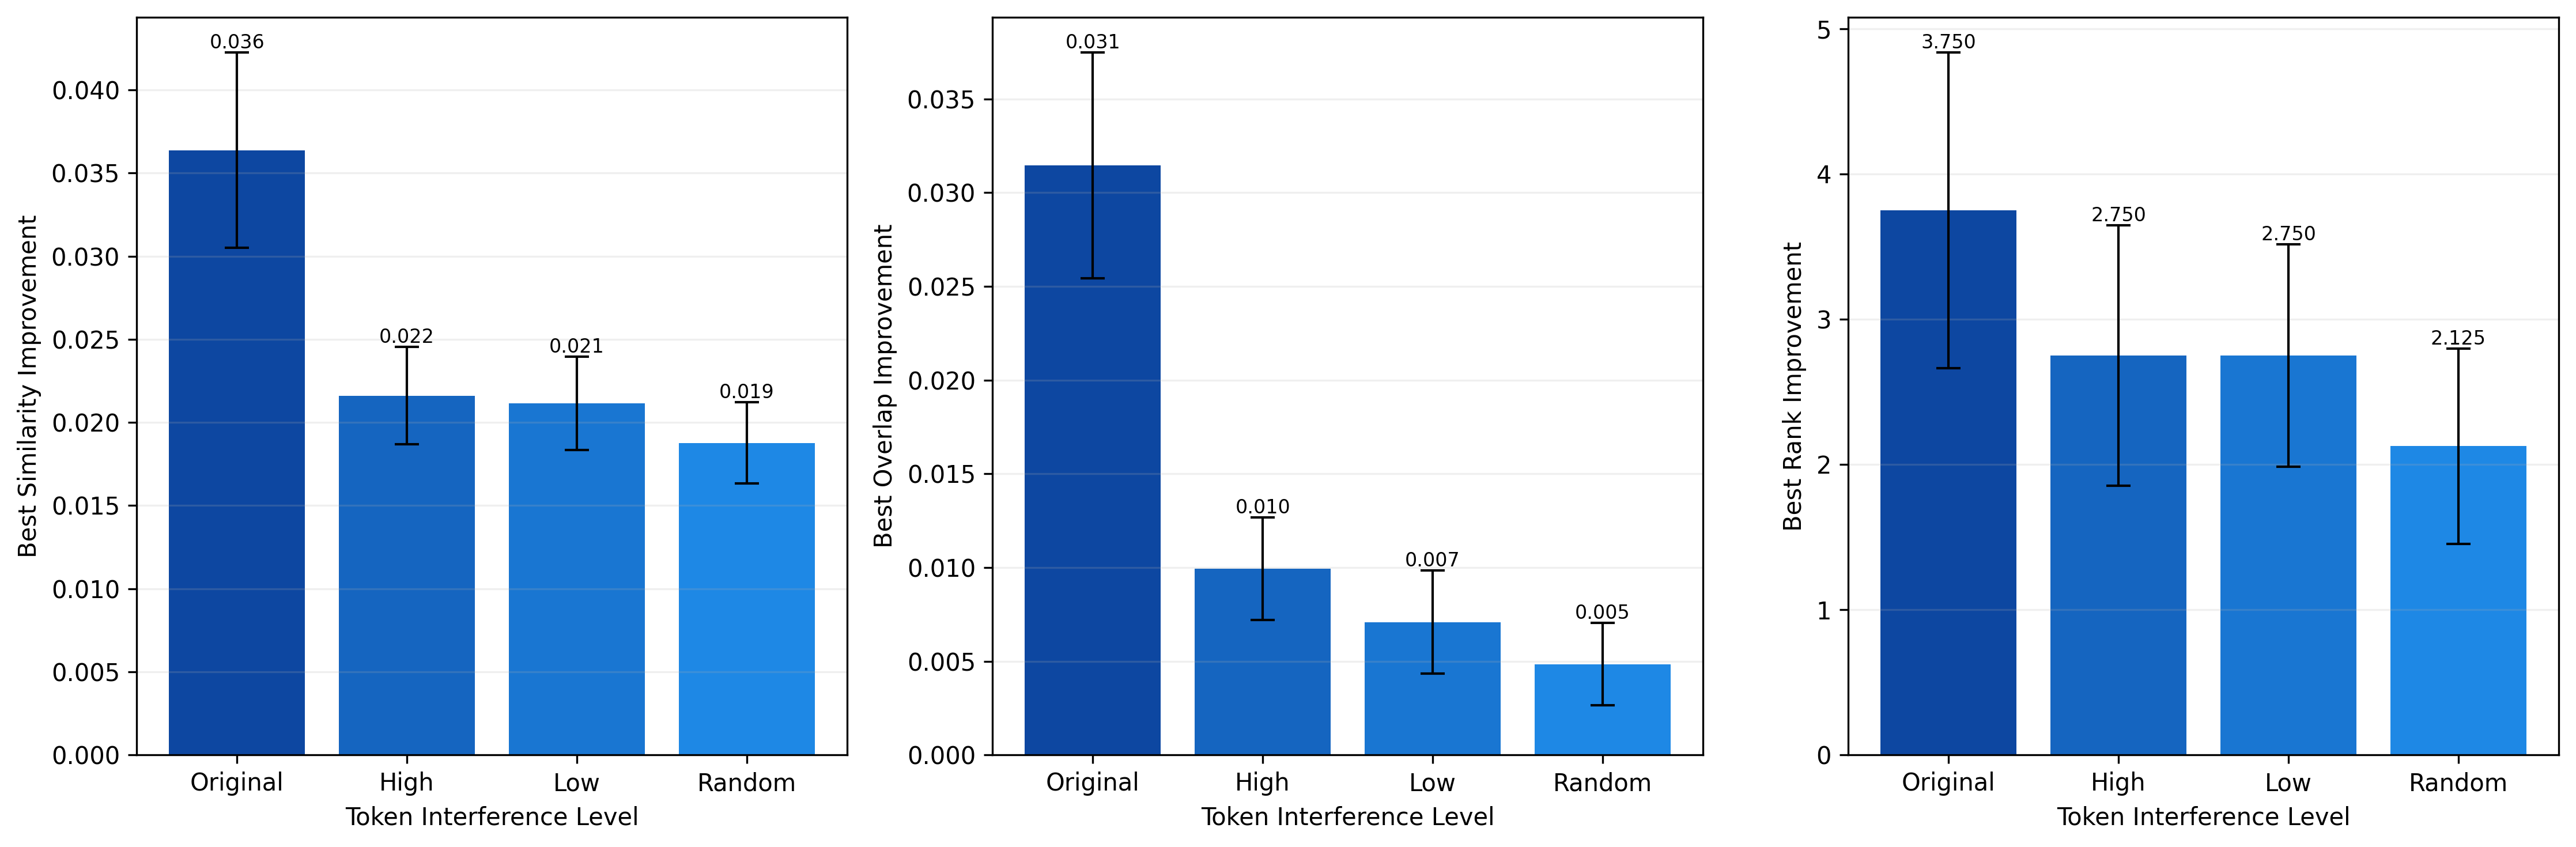

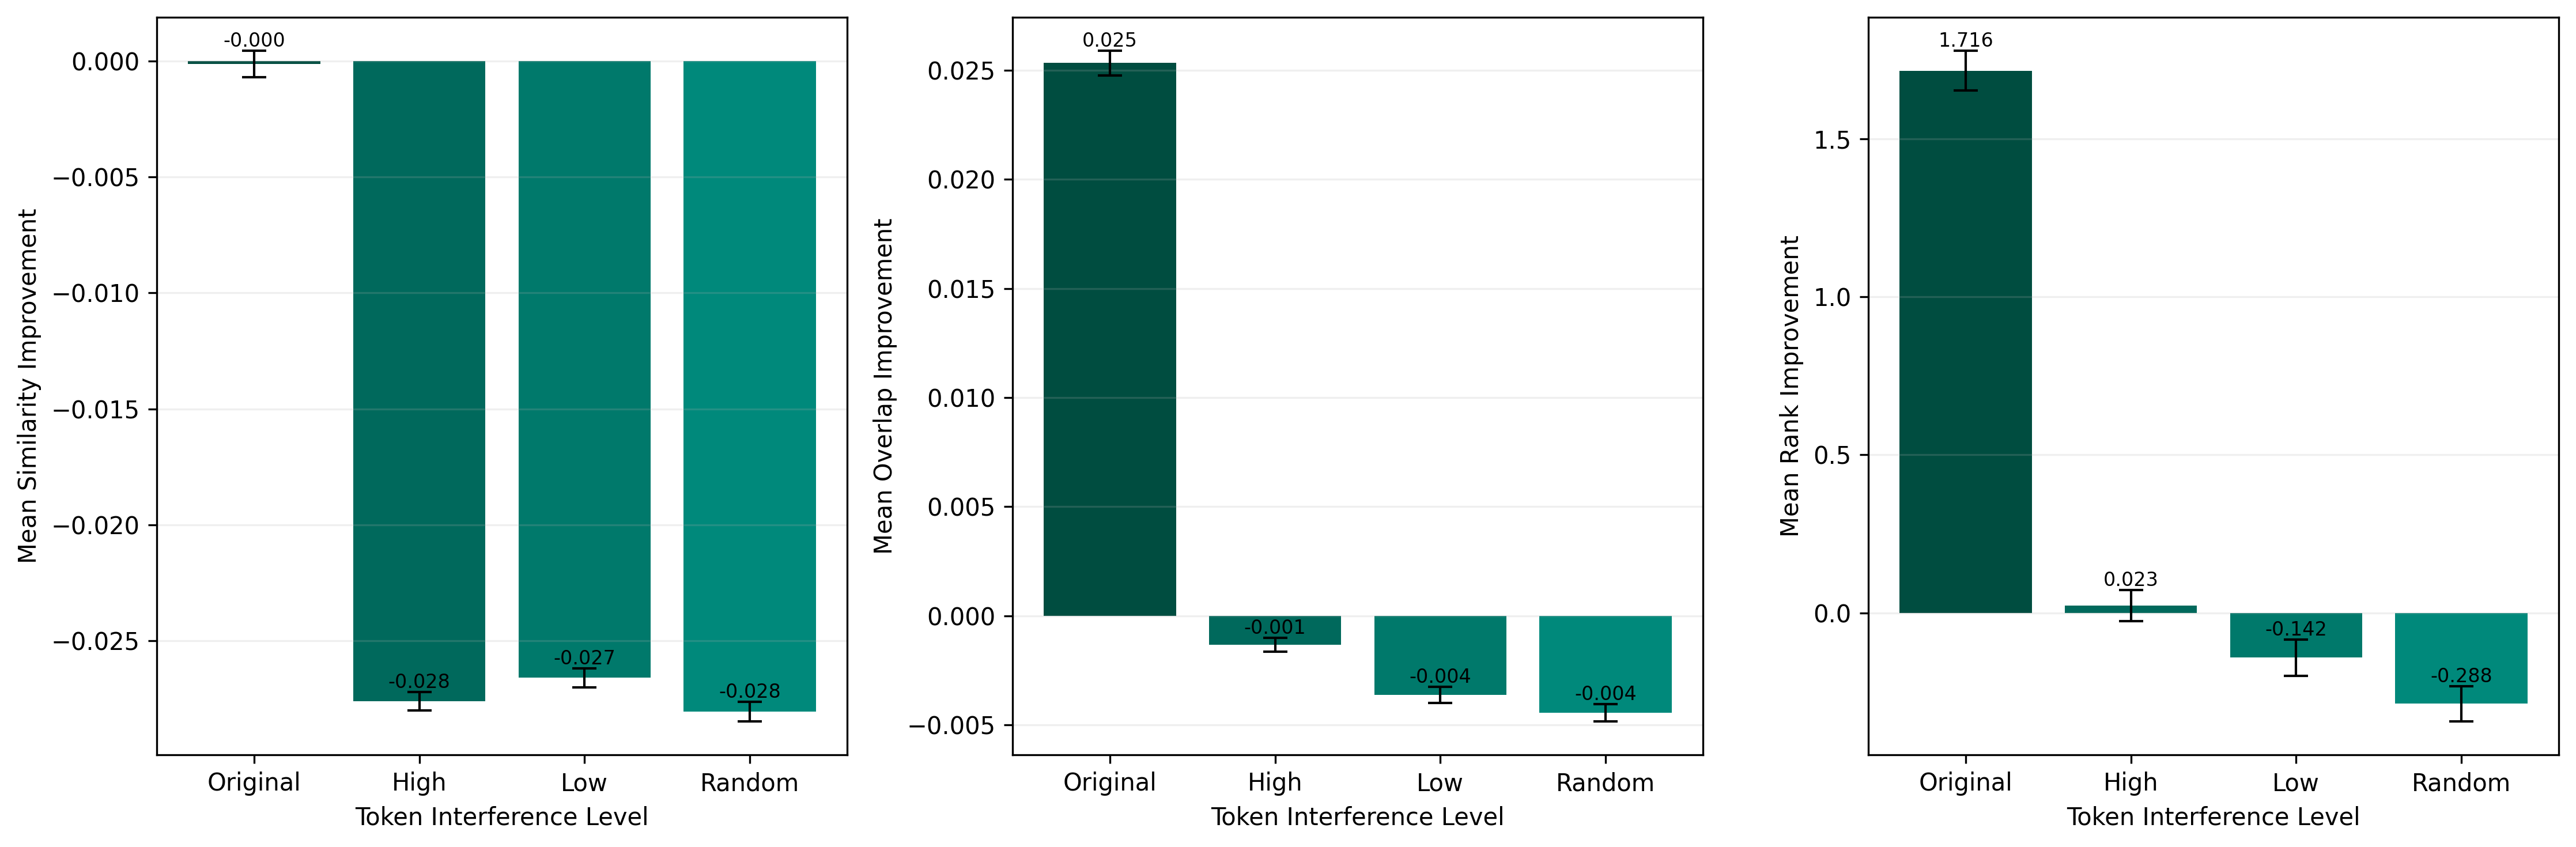

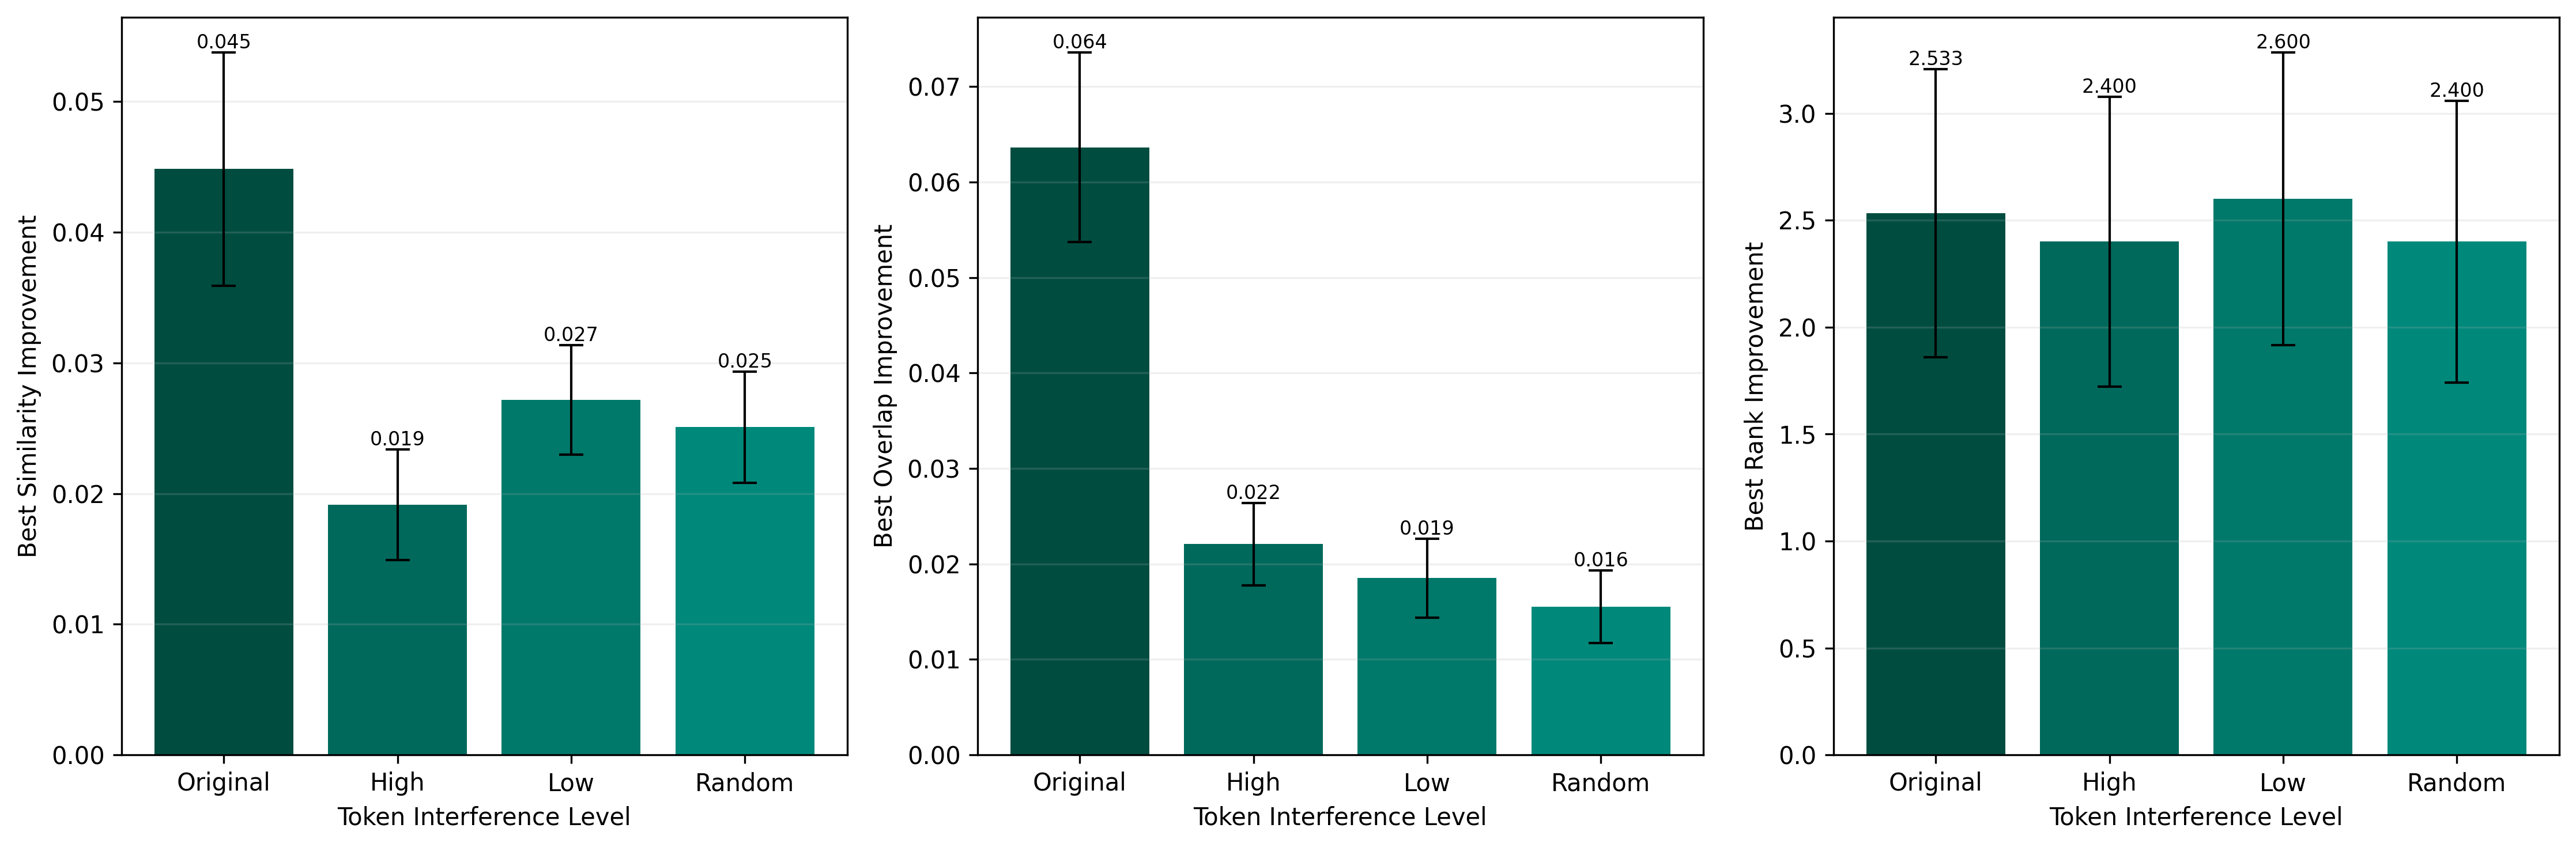

In [12]:
# Analyze results
print("\n=== Love&Hate Statistical Analysis ===")
compare_all_groups(pythia_love_hate_results, 'love_hate', "Pythia")
print_experiment_results(pythia_love_hate_results, "Pythia", "Love&Hate")
compare_all_groups(gpt2_love_hate_results, 'love_hate', "GPT-2")
print_experiment_results(gpt2_love_hate_results, "GPT-2", "Love&Hate")

# Plot love hate experiment results
plot_injection_metrics(pythia_love_hate_results, "Pythia", "Love&Hate")
plot_best_improvements(pythia_love_hate_results, "Pythia", "Love&Hate")
plot_injection_metrics(gpt2_love_hate_results, "GPT-2", "Love&Hate")
plot_best_improvements(gpt2_love_hate_results, "GPT-2", "Love&Hate")